# Stabilizing selection

Explore the consequences of stabilizing selection on LD

Yair, S., & Coop, G. (2022). Population differentiation of polygenic score predictions under stabilizing selection. Philosophical Transactions of the Royal Society of London. Series B, Biological Sciences, 377(1852), 20200416.

From Yair and Coop Appendix A1:

$$
\begin{align}
W(\vec{r}) = \mathrm{exp}\left( -\frac{r^2}{2w^2} \right)
\end{align}
$$

where $r = \|\vec{r}\| $ is the phenotypic distance from optimum for an individual with vector of phenotypes $\vec{r}$ and $w$ the width of the fitness peak.

Here we'll define $\| \vec{r} \|$ as the absolute value of the sum of effect sizes for mutations:

$$
\begin{align}
r &= \sum_{i=1}^n a_i 
\end{align}
$$

## Model of stabilizing selection

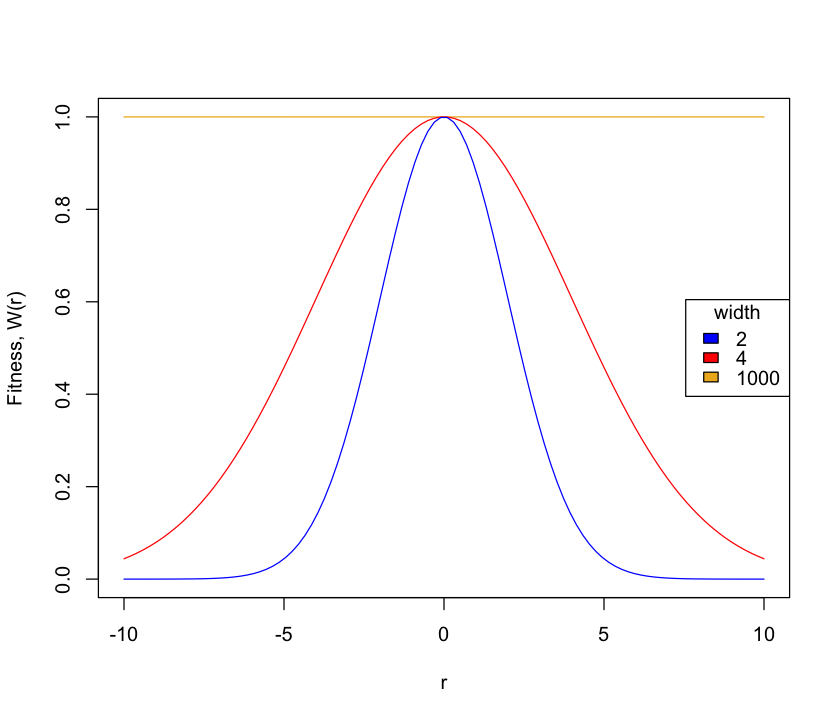

In [2]:
r <- rnorm(100)

x <- seq(-10,10, length=100)

options(repr.plot.width=7, repr.plot.height=6)
w <- 1000
plot(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', ylim=c(0,1), col='goldenrod2')
w <- 4
points(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', col='red')
w <- 2
points(x, exp(-x^2/(2*w^2)), type='l', xlab='r', ylab='Fitness, W(r)', col='blue')
legend('right', c('2','4','1000'), fill=c('blue', 'red', 'goldenrod2'), title = 'width')



$$
\begin{align}
s &\approx \frac{\sum_{i=1}^{n}a_{i}^2}{w^2} \\
\end{align}
$$

where $a_i$ denotes allele's effect on trait $i$ and $w$ is the width of stabilizing peak under Gaussian stabilizing selection.

## r06.1 (stabilizing selection, epistasis)

Publication Fig 6, Supp Fig 12

Here we show the LD and $\xi$ results from a forward evoluationary
simulation on a stabilizing selection (epistatic) model. This demonstrates
positive LD between opposite-effect SNPs, and negative LD between
concordant-effect SNPs.

- Fixed population size N=10000
- Recombination 1e-8
- Mutation rate 1e-8
- For each run, variant effect of either $+\beta$ or $-\beta$
- No downsampling for LD calculations
- 5000 iterations

### Simulation run

```bash
pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r06.1
```

```bash
RUN=r06.1
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=4801-5000%20 \
            -c 1 \
            -t 0-01:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

### Compute snp-pair effect

Here we calculate the snp-pair effect $\xi$ in different slices of the data.

This is a rescue of `slim_generator.sh`, which runs `parse_vcf_gravel.py` because in the default run, it uses different definitions of low/common allele frequencies. Therefore, we can reuse the simulation run but just summarize the snp-pair effect over different variant pairs.

The relevant script here is `calc_covar.py`, which computes the covariance among the desired classes

In this run class is defined as follows. (note that ancestral/derived status is being ignored here per Martin's protocol for the empirical data):
- Low frequency: MAF 0.05% - 5%
- Common: MAF 5%-95% (inclusive)
- Split into positive and negative LD classes.

In the publication, we only present the data for WIDTH=2, BETA=1e-1.

```bash
RUN=r06.1

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-500%20 \
            -c 1 \
            -t 0-00:30 \
            --mem=500M \
            -p short \
            -J covar.$RUN.w${WIDTH}.b${BETA} \
            -o log/covar.$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_covar_batch.sh \
                -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 # 1e-2 1e-3 1e-4
do
    for WIDTH in 2 # 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [182]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [183]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [184]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


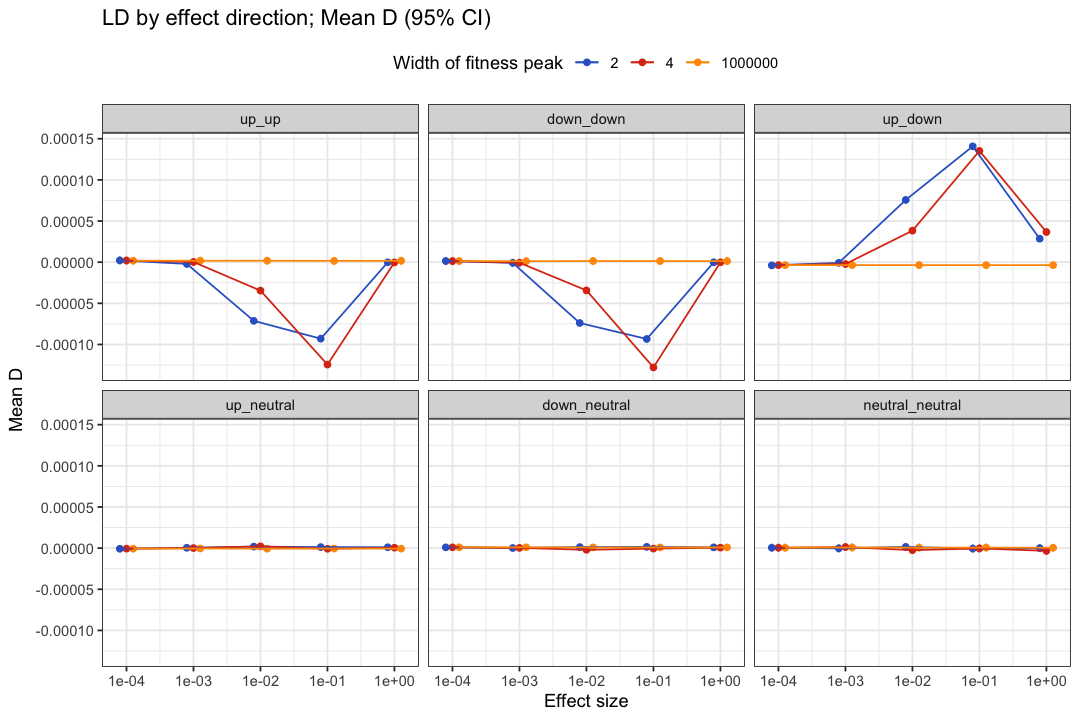

In [185]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### Simplified fig

In [239]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [240]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [241]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

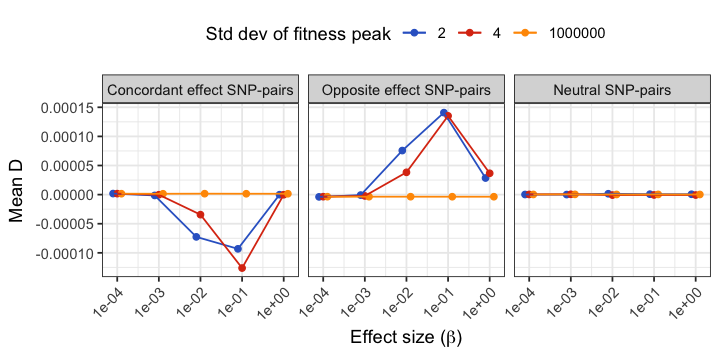

In [242]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta Covariance detail

In [328]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [329]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [330]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [331]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("low-low", "common-low", "common-common"))

In [332]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("100", "1000", "10000", "100000"),
                  labels = c("0-100bp", "100bp-1kb", "1-10kb", "10-100kb"))

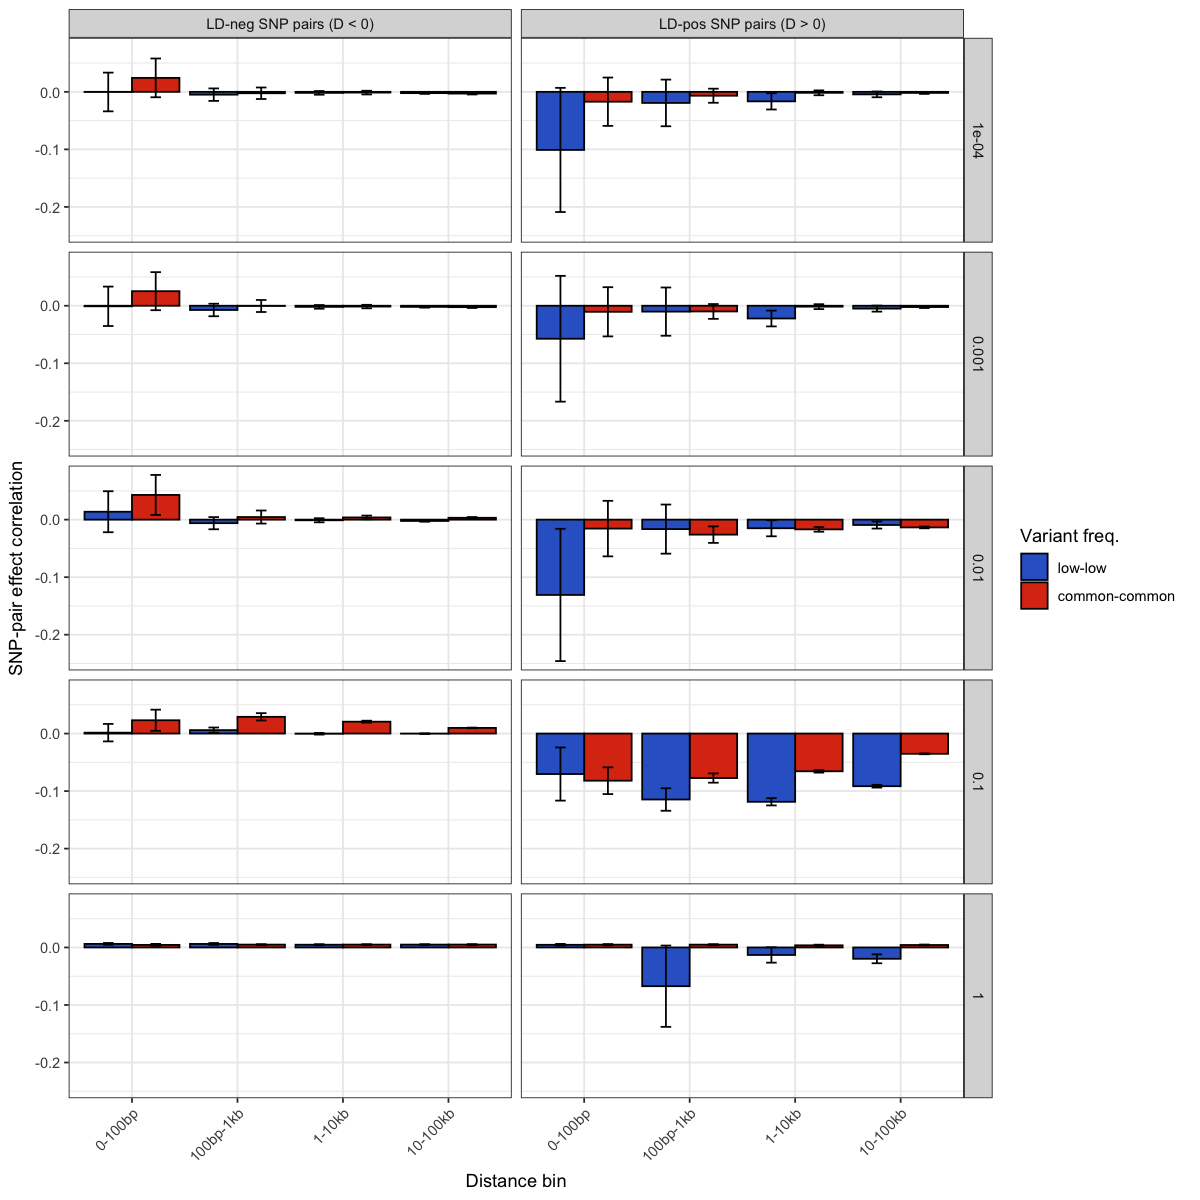

In [333]:
# w <- 6
# h <- 2.5

w <- 10
h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg SNP pairs (D < 0)", "LD-pos SNP pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
#                              & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

# p <- p + facet_grid(beta  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-1.pdf', h=h, w=w)
# print(p)
# dev.off()

##### Beta Covariance simple (main text Fig. 6)

Stratified by distance

pdf 
  2

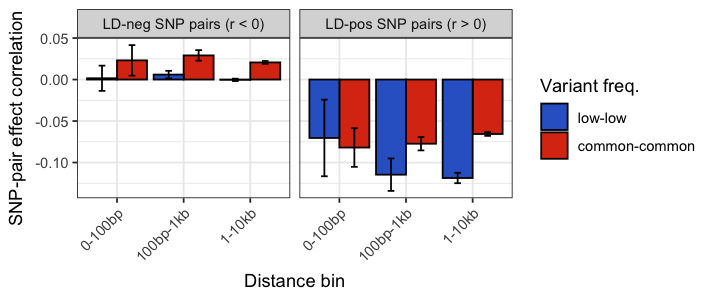

In [336]:
w <- 6
h <- 2.5

# w <- 10
# h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg SNP pairs (r < 0)", "LD-pos SNP pairs (r > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

p <- p + facet_grid(.  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1.pdf', h=h, w=w)
print(p)
dev.off()

In [345]:
# Output raw data for publication:
out.data <- dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,] %>%
        mutate(CI95.low = mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)) %>%
        mutate(CI95.high = mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE))

write.csv(out.data, 'figs/fig5_data.csv')

#### Beta covariance (Stratified by LD)

In [322]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [323]:
dat <- read.csv('summary_cov.ld.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [324]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [325]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("low-low", "common-low", "common-common"))

In [326]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("100", "1000", "10000", "100000"),
                  labels = c("0-100bp", "100bp-1kb", "1-10kb", "10-100kb"))

pdf 
  2

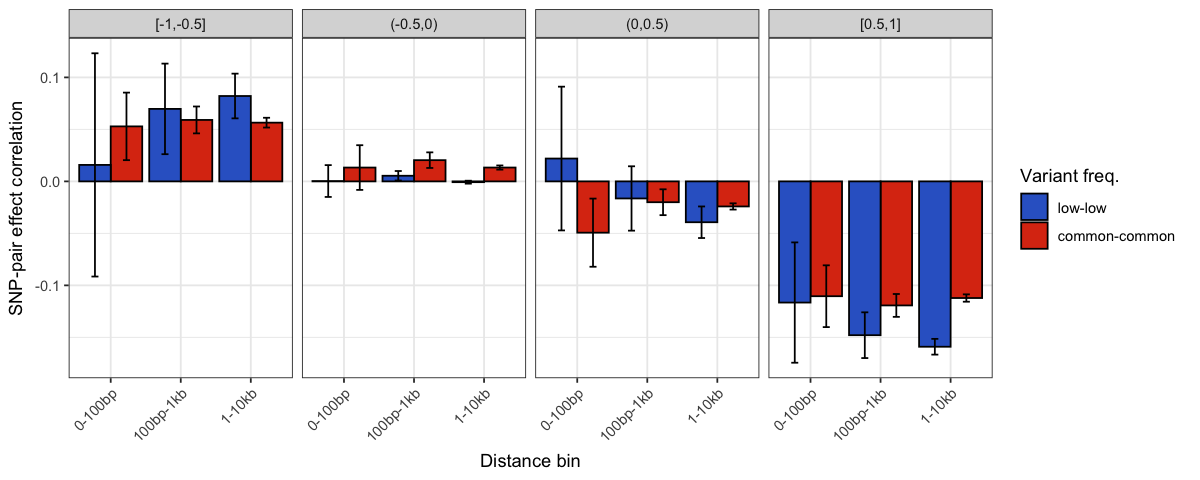

In [327]:
w <- 10
h <- 4

# w <- 10
# h <- 10


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# # New facet label names for corr_class variable
# corr_class.labs <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")
# names(corr_class.labs) <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")

# dat$corr_class <- ordered(dat$corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]"))

p <- ggplot(data=dat_summary[!is.na(dat_summary$class)
                             & dat_summary$bin != "10-100kb"
                             & dat_summary$class != "common-low"
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

p <- p + facet_grid(.  ~ factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1_ldbins.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta covariance, no distance bins
- Stratified by LD
- No distance bins

In [283]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [284]:
dat <- read.csv('summary_cov.ld.nodist.min_frq_0.txt.gz', header=T)

In [290]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin'. You can override using the `.groups` argument.


In [291]:
# rename ranges
dat_summary$bin <- factor(dat_summary$bin, levels = c("10000", "100000"),
                  labels = c("0-10kb", "10-100kb"))

pdf 
  2

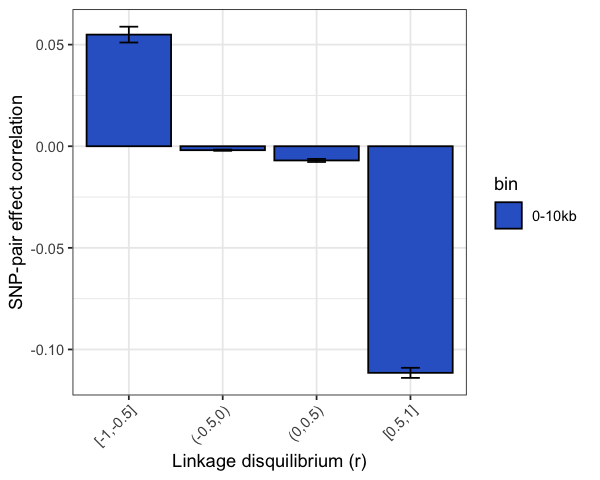

In [310]:
# w <- 10
# h <- 4

w <- 5
h <- 4

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# # New facet label names for corr_class variable
# corr_class.labs <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")
# names(corr_class.labs) <- c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")

# dat$corr_class <- ordered(dat$corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]"))

p <- ggplot(data=dat_summary[dat_summary$bin=='0-10kb'
                             & dat_summary$width==2
                             & dat_summary$beta==1e-1
                             ,],
            aes(x=factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")), y=mean,
               fill=bin)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

# p <- p + facet_grid(.  ~ factor(corr_class, levels=c("[-1,-0.5]", "(-0.5,0)", "(0,0.5)", "[0.5,1]")))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Linkage disquilibrium (r)')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
# p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-1_ldbins_nodist.pdf', h=h, w=w)
print(p)
dev.off()

## r06.2 (no epistasis)

Here, we try to differentiate the stabilizing selection model from the null hypothesis
(non-epistatic regime). We know that without epistasis we will see Hill-Robertson
interference causing negative LD in weakly selected variants.

- simulation of __directional selection__ (only neutral and trait decreasing variants)
- Fixed population size N=10000
- Recombination
- No downsampling for LD calculations
- 2023-08-28: Problem with colliding seeds under certain selection parameters, so multiplying SEED by WIDTH
- (Publication quality version of `r04.3`)

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -s 10 \
    -d pop_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d dom_coeff=0.5 \
    -d reg_length=100000 \
    -d recomb_rate=1e-8 \
    -d mu=1e-8 \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Simulation run

```bash
pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r06.2
```

```bash
RUN=r06.2
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=2101-2700%50 \
            -c 1 \
            -t 0-01:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only
- This is not needed

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [218]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [219]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [220]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


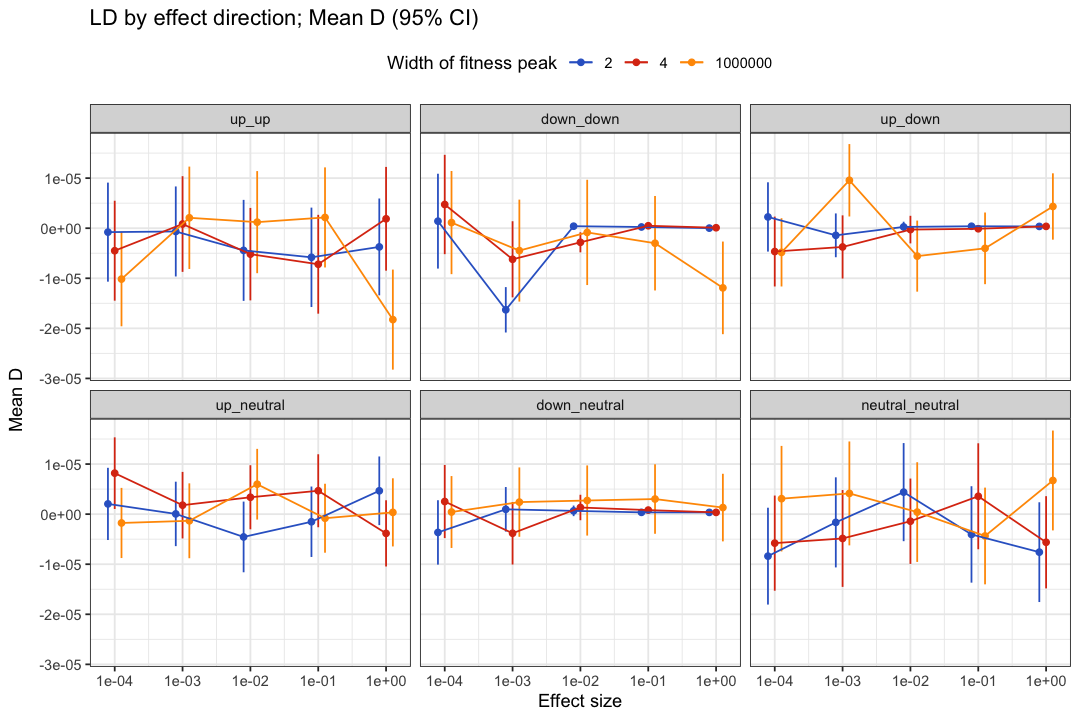

In [221]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### Simplified fig

In [222]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [223]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [224]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

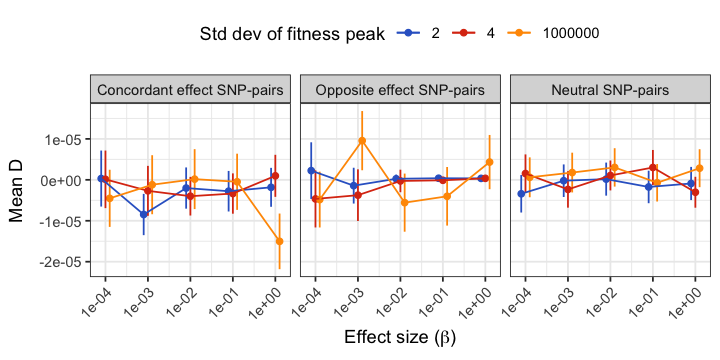

In [225]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### Beta covariance

In [226]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [227]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [228]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [229]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

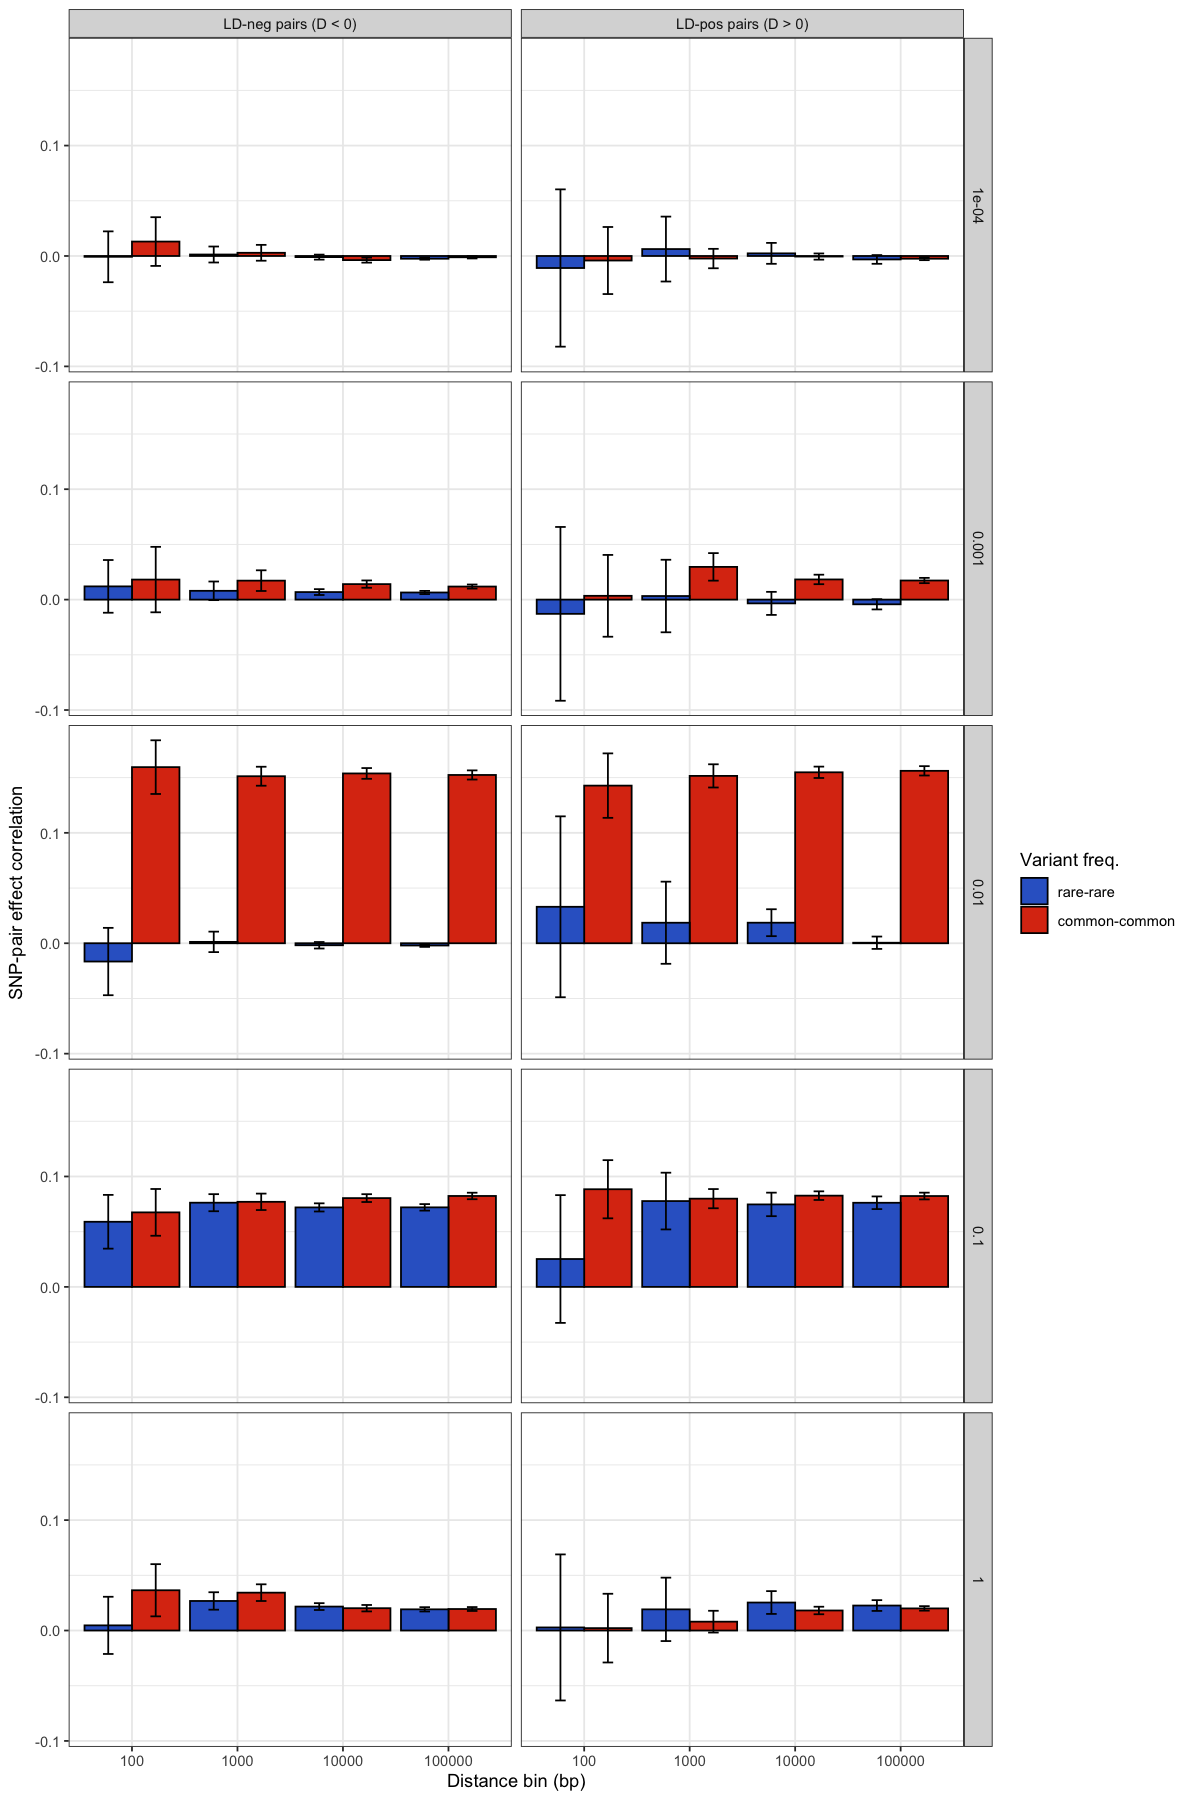

In [230]:
# w <- 6
# h <- 2.5

w <- 10
h <- 15


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

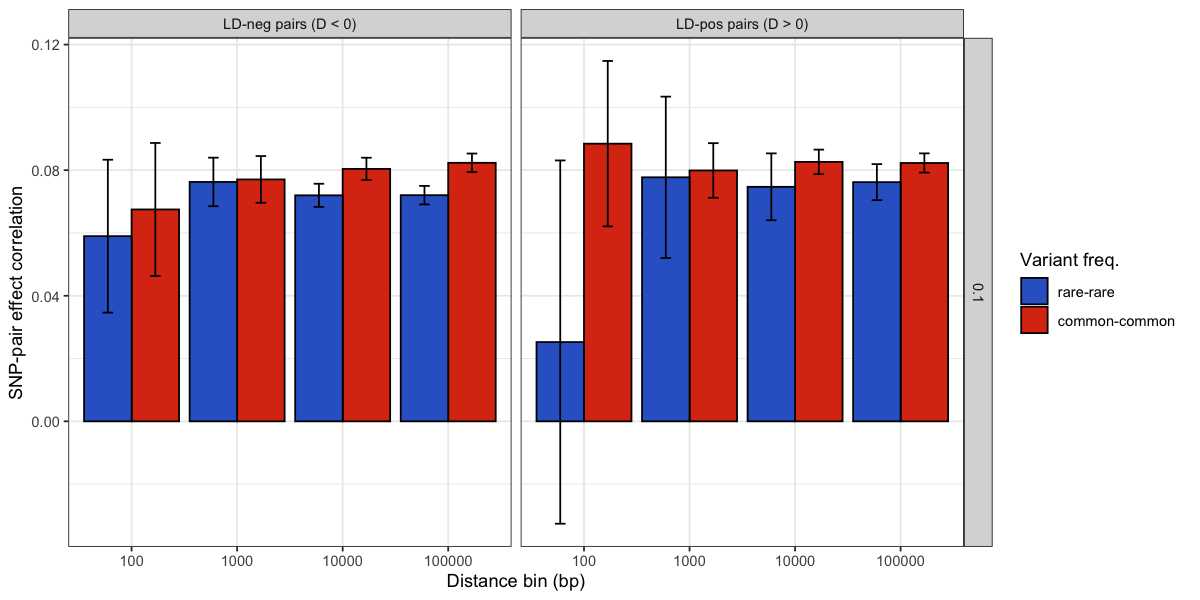

In [231]:
# w <- 6
# h <- 2.5

w <- 10
h <- 5


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

# Notes

2023-05-30 meeting
- code from VCF
- harmonize with arun
--- (stabilizing model)
--- population model

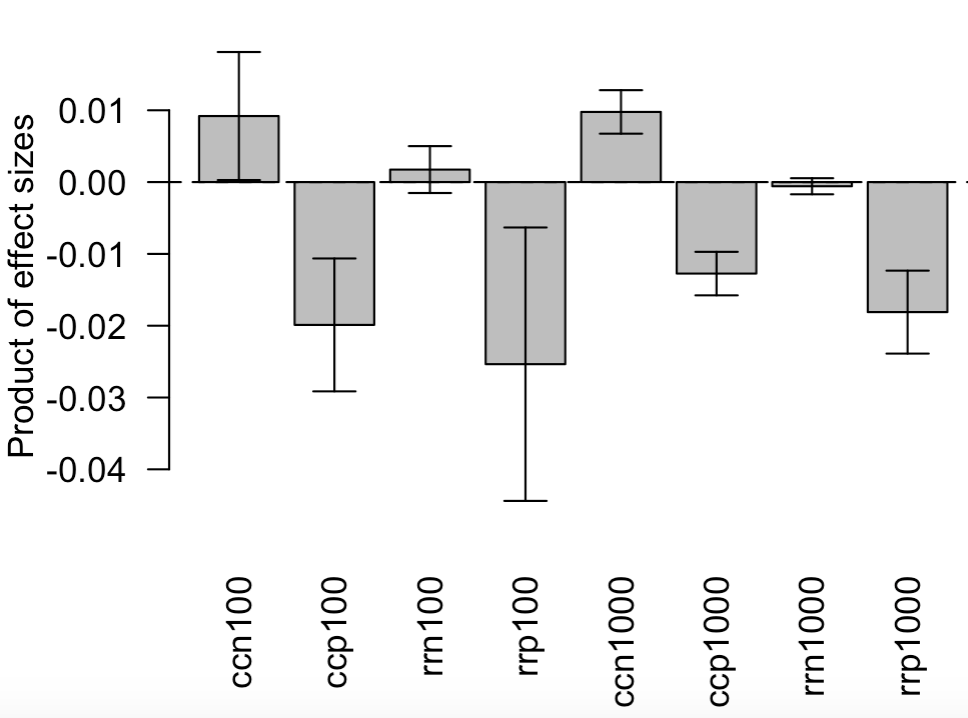

```bash
cat 1.vcf  | vawk --header '{ if (I$MT==1) {S=0}; if (I$MT==2) {S=-1}; if (I$MT==3) {S=1}; gsub("S=[0-9]*;","S="S";",$8); print }' > 1.recal.vcf

```

# UK BioBank

```bash
pwd
# /n/data2/bwh/genetics/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/ukbb_2021-09-29

wget -c https://storage.googleapis.com/broad-alkesgroup-public/UKBB/body_HEIGHTz.sumstats.gz
        
zcat body_HEIGHTz.sumstats.gz | sed 1d | awk '{ print "chr"$2,$3-1,$3,$0 }' OFS="\t" | liftOver -bedPlus=3 /dev/stdin $SUNYAEV/annotations/genomes/hg19/hg19ToHg38.over.chain newFile unmapped

cat newFile \
    | awk '{ gsub("^chr","",$1); $5=$1; $6=$3; print }' OFS="\t" \
    | cut -f 4- \
    | cat <(zcat body_HEIGHTz.sumstats.gz | head -n 1) - \
    | gzip -c \
    > body_HEIGHTz.liftOver_hg38.sumstats.gz

# make BED file
zcat body_HEIGHTz.liftOver_hg38.sumstats.gz \
    | awk '{ print "chr"$2,$3-1,$3,$1,$4,$5,$6,$7,$8,$9,$10,$11,$12 }' OFS='\t' \
    | sed 1d \
    | sort -k1,1V -k2,2g -k3,3g -S 500M -T ./ \
    | bgzip -c \
    > body_HEIGHTz.liftOver_hg38.sumstats.bed.gz
tabix -f body_HEIGHTz.liftOver_hg38.sumstats.bed.gz
```

### Get unrelated 1000 Genomes EUR samples (from file of 2504 samples)

```bash

# unrelated sample list
wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/working/20130606_sample_info/20130606_g1k.ped

bcftools query -l $SUNYAEV/data/1000G/CCDG_13607_B01_GRM_WGS_2019-02-19_chr1.recalibrated_variants.vcf.gz \
    > 1000G_unrelated_2504.txt


zjoin -a 20130606_g1k.ped -b $SUNYAEV/data/1000G_phased/pop_map.txt \
    -1 7 -2 1 \
    | awk '$NF=="EUR"' \
    | cut -f 2 \
    | zjoin -a 1000G_unrelated_2504.txt -b stdin \
    | cut -f 1 \
    > 1000G_unrelated_EUR.txt

wc -l 1000G_unrelated_EUR.txt
# 503 1000G_unrelated_EUR.txt
```

### Make a VCF file with only associated variants

```bash
# shortcut:

mkdir -p log
for CHROM in {22..22}
do
    sbatch \
        -c 1 \
        --mem=16G \
        -t 0-04:00 \
        -p short \
        -J make.${CHROM} \
        -o log/make.${CHROM}.%A.out \
        ./make_chr_vcf.sh ${CHROM}
done
        
```


### Run emeraLD on each of the chunks

```bash
# emeraLD: /home/cc514/code/emeraLD
git rev-parse HEAD
# dfc414e4f3026aab42e3e7b212e2d502a45de4fc

for CHROM in {22..22}
do
    mkdir -p chr${CHROM}/ld

    echo ./emerald_run.sh chr${CHROM}/vars.vcf.gz chr${CHROM}/ld/ld.txt.gz
    sbatch \
        -c 1 \
        --mem=8G \
        -t 0-04:00 \
        -p short \
        -o log/slurm-%j.out \
        -e log/slurm-%j.out \
        -J ld.$CHROM \
        ./emerald_run.sh chr${CHROM}/vars.vcf.gz chr${CHROM}/ld/ld.txt.gz
done
```

### Filter LD

```bash
for CHROM in {22..22}
do
    sbatch \
        -c 1 \
        --mem=16G \
        -t 0-04:00 \
        -p short \
        -o log/filt.$CHROM.%A.out \
        -e log/filt.$CHROM.%A.out \
        -J filt.$CHROM \
        ./filter_ld.sh chr${CHROM}/annot.txt.gz chr${CHROM}/ld/ld.txt.gz ${CHROM}
done

```

Collapse into single file

```bash
for CHROM in {22..22}
do
    zcat chr${CHROM}/ld/ld.filt.txt.gz
done \
    | awk '{ if (NR==1 || $0!~"^#") print }' \
    | awk 'NF==36' \
    | gzip -c \
    > full.ld.filt.txt.gz

```

## R session

In [276]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/ukbb_2021-09-29')

library('ggplot2')
library('ggthemes')
library('dplyr')
options(repr.plot.width=12, repr.plot.height=9)

In [273]:
dat <- read.table('head10k.txt.gz', header=T)

In [274]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

ERROR: Error: Must group by variables found in `.data`.
* Column `width` is not found.
* Column `effect` is not found.
* Column `type` is not found.


In [275]:
?geom_density

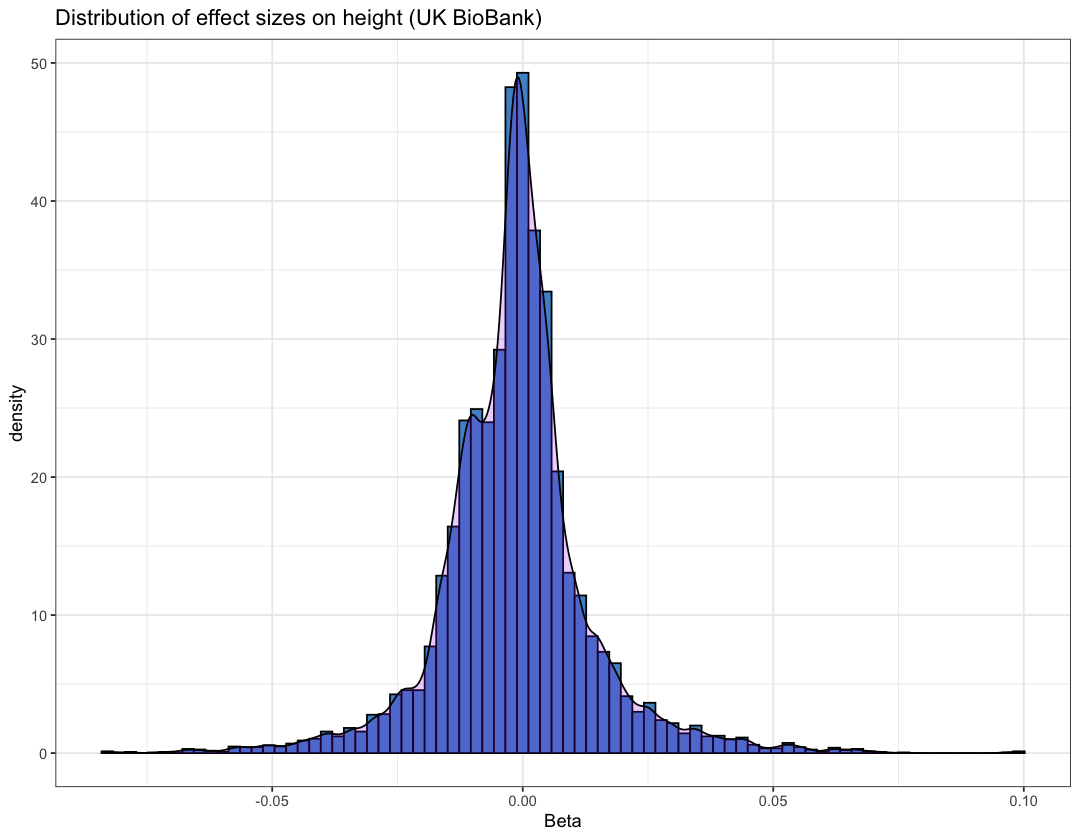

In [253]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat, aes(x=Beta)) + theme_bw() + scale_color_gdocs()
p <- p + geom_histogram(aes(y = ..density..), bins=80, fill='steelblue3', col='black')
p <- p + geom_density(fill='purple', alpha=0.2)
p <- p + ggtitle('Distribution of effect sizes on height (UK BioBank)')
print(p)

### LD Data

In [277]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/ukbb_2021-09-29')

df <- read.table('full.ld.filt.txt.gz', header=T, comment.char = "")

#### Polarize LD

In [284]:
df$flipA <- (df$refA==df$ancesA) * 2 - 1
df$flipB <- (df$refB==df$ancesB) * 2 - 1
df$D_pol <- df$D * df$flipA * df$flipB
df$Dprime_pol <- df$Dprime * sign(df$D_pol)

In [471]:
set.seed(10)
df$flipA_rand <- sample(c(-1,1), nrow(df), replace=T)
df$flipB_rand <- sample(c(-1,1), nrow(df), replace=T)

df$D_pol_rand <- df$D * df$flipA_rand * df$flipB_rand
df$Dprime_pol_rand <- df$Dprime * sign(df$D_pol_rand)

#### Dataset cuts

In [511]:
# b <- seq(0,40,10)
b <- c(0,10,20,100)
df$caddA_bin <- cut(df$caddA, breaks=b, right=FALSE)
df$caddB_bin <- cut(df$caddB, breaks=b, right=FALSE)

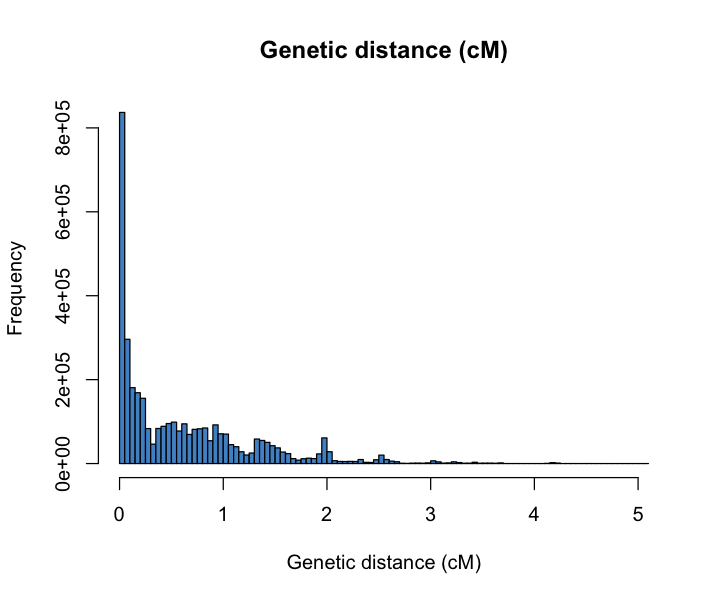

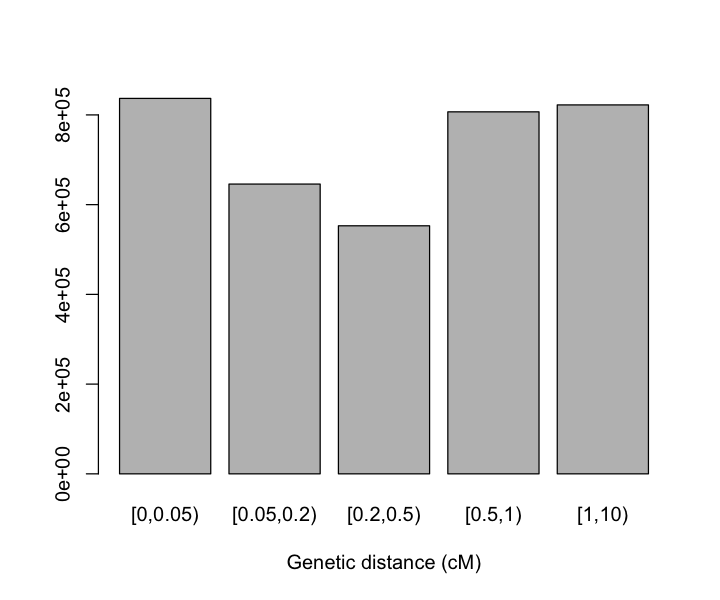

In [512]:
df$gd <- abs(df$gdistA - df$gdistB)
b <- c(0,5e-2,2e-1,5e-1,1,10)
# b <- quantile(df$gd, probs = seq(0, 1, length=6), na.rm = T)
df$gd_bin <- cut(df$gd, breaks=b, right=FALSE)

options(repr.plot.width=6, repr.plot.height=5)
hist(df$gd, breaks=100, main='Genetic distance (cM)', xlab='Genetic distance (cM)', col='steelblue3')
plot(df$gd_bin, xlab='Genetic distance (cM)')

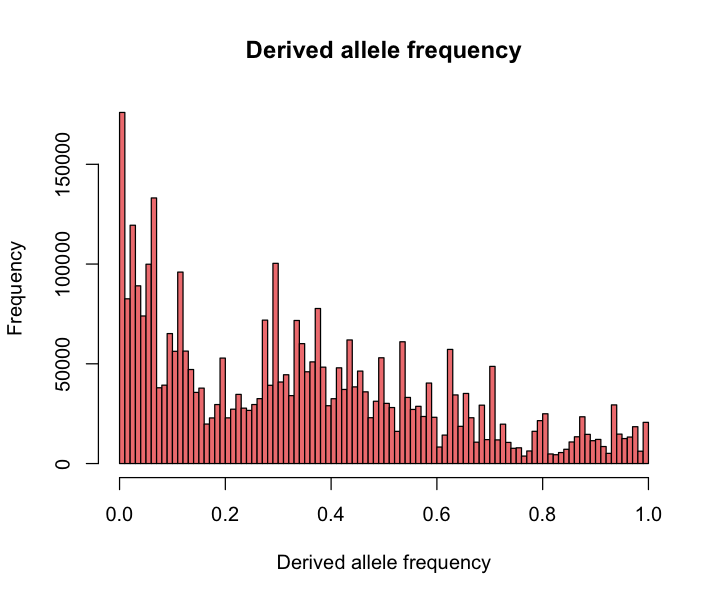

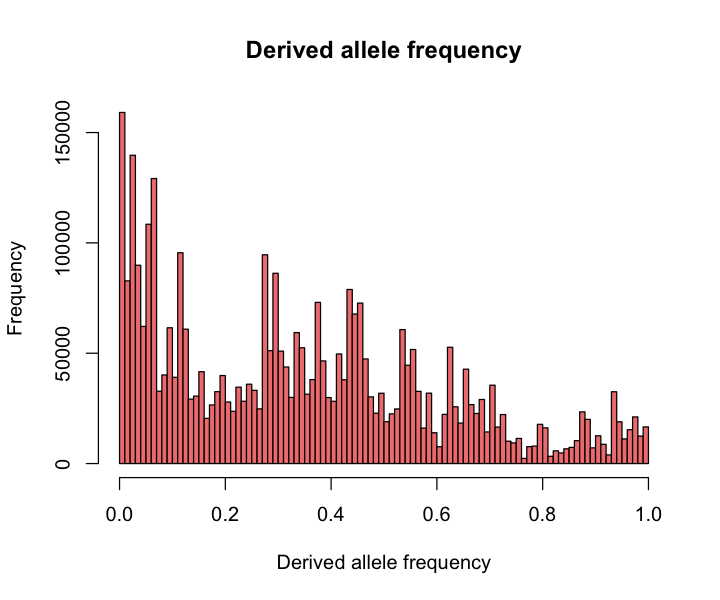

In [513]:
df$dafA <- (1 + df$aafA * df$flipA)%%1
df$dafB <- (1 + df$aafB * df$flipB)%%1

# plot derived allele frequency
options(repr.plot.width=6, repr.plot.height=5)
hist(df$dafA, breaks=100, col='lightcoral', main='Derived allele frequency',
     xlab='Derived allele frequency')

hist(df$dafB, breaks=100, col='lightcoral', main='Derived allele frequency',
     xlab='Derived allele frequency')

# x <- seq(0,1,1e-3)
# lines(x, 1/x, type='l', col='red')

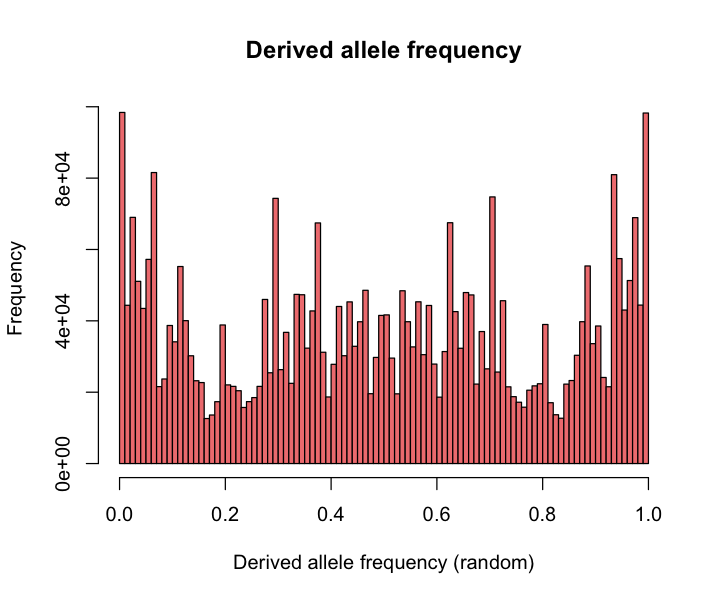

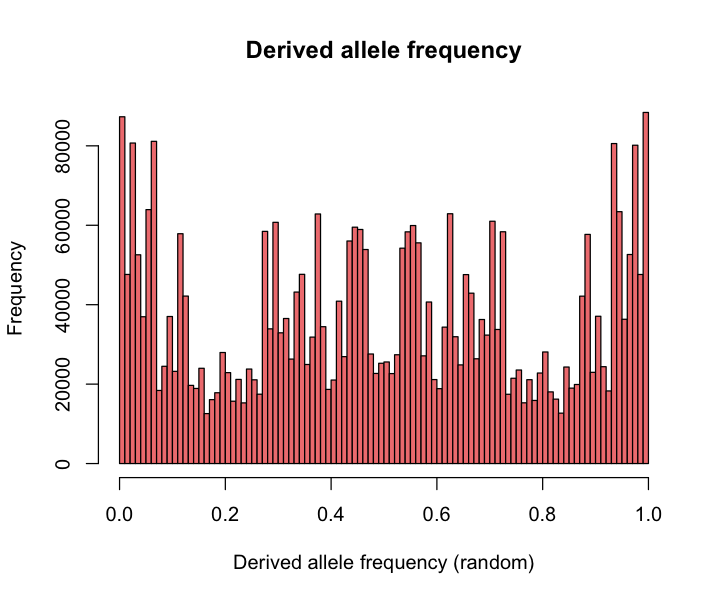

In [514]:
df$dafA_rand <- (1 + df$aafA * df$flipA_rand)%%1
df$dafB_rand <- (1 + df$aafB * df$flipB_rand)%%1

# plot derived allele frequency
options(repr.plot.width=6, repr.plot.height=5)
hist(df$dafA_rand, breaks=100, col='lightcoral', main='Derived allele frequency',
     xlab='Derived allele frequency (random)')

hist(df$dafB_rand, breaks=100, col='lightcoral', main='Derived allele frequency',
     xlab='Derived allele frequency (random)')

# x <- seq(0,1,1e-3)
# lines(x, 1/x, type='l', col='red')

In [515]:
b <- seq(0,1,0.1)
df$dafA_bin <- cut(df$dafA, breaks=b)
df$dafB_bin <- cut(df$dafB, breaks=b)

In [516]:
b <- c(-1000,0,1000)
# must polarize!
df$betaA_pol <- df$betaA * df$flipA
df$betaB_pol <- df$betaB * df$flipB

df$betaA_pol_sign <- cut(df$betaA_pol, breaks=b, labels=c('neg', 'pos'))
df$betaB_pol_sign <- cut(df$betaB_pol, breaks=b, labels=c('neg', 'pos'))

df$beta_align <- as.factor(paste0(df$betaA_pol_sign, "_", df$betaB_pol_sign))
levels(df$beta_align) <- list(same = "pos_pos", same = "neg_neg", opp = "pos_neg", opp  = "neg_pos")

In [517]:
# random beta
b <- c(-1000,0,1000)
df$betaA_pol_rand <- df$betaA * df$flipA_rand
df$betaB_pol_rand <- df$betaB * df$flipB_rand

df$betaA_pol_sign_rand <- cut(df$betaA_pol_rand, breaks=b, labels=c('neg', 'pos'))
df$betaB_pol_sign_rand <- cut(df$betaB_pol_rand, breaks=b, labels=c('neg', 'pos'))

df$beta_align_rand <- as.factor(paste0(df$betaA_pol_sign_rand, "_", df$betaB_pol_sign_rand))
levels(df$beta_align_rand) <- list(same = "pos_pos", same = "neg_neg", opp = "pos_neg", opp  = "neg_pos")

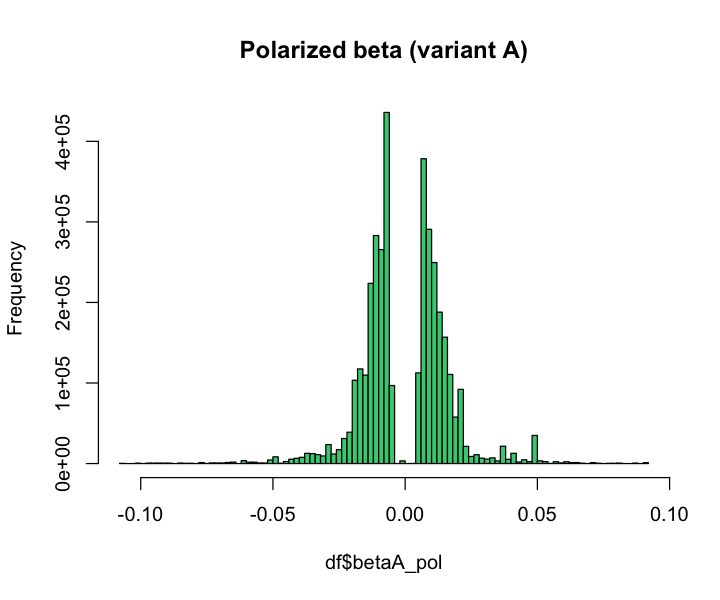

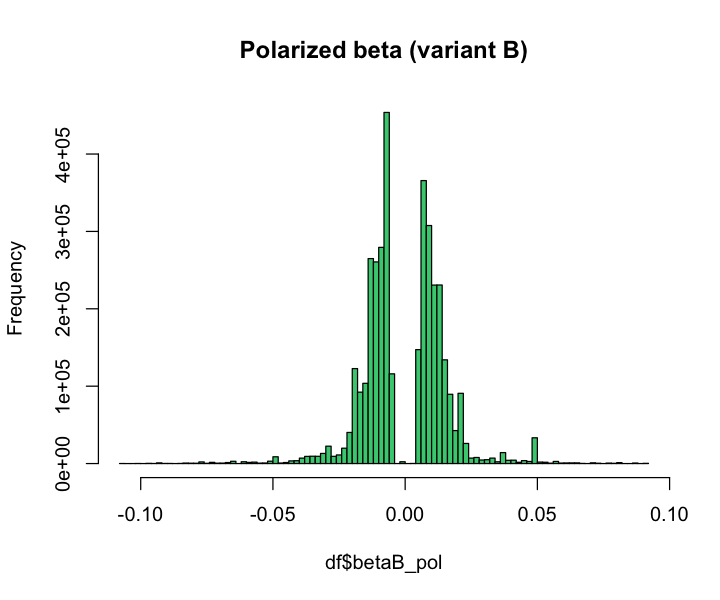

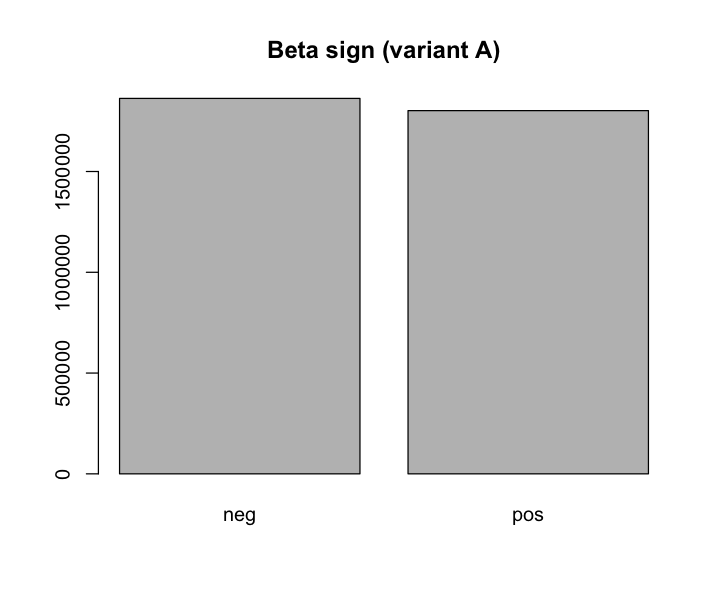

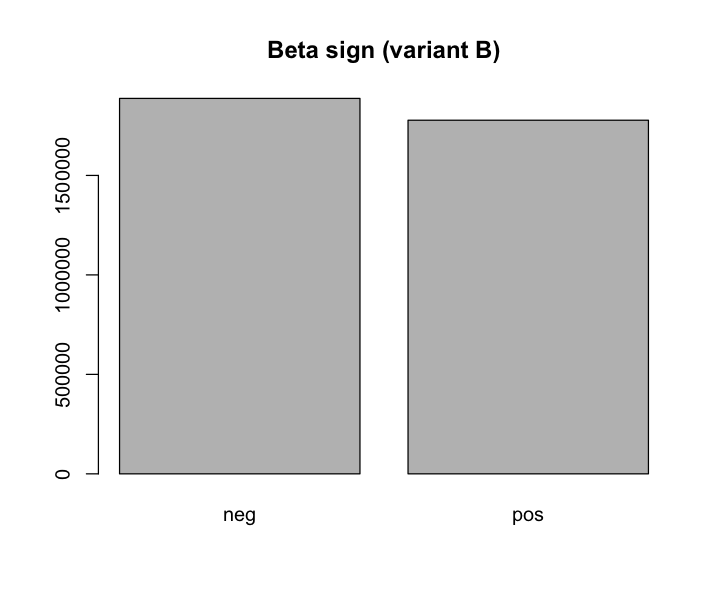

In [518]:
options(repr.plot.width=6, repr.plot.height=5)
hist(df$betaA_pol, breaks=100, col='seagreen3', main='Polarized beta (variant A)')
hist(df$betaB_pol, breaks=100, col='seagreen3', main='Polarized beta (variant B)')
plot(df$betaA_pol_sign, main='Beta sign (variant A)')
plot(df$betaB_pol_sign, main='Beta sign (variant B)')

#### All genes (DAF ≤ 1, i.e. no freq filter)

##### D

In [559]:
maxAF <- 1
pVal_max <- 1e-10

df.filt <- df[!is.na(df$gd_bin)
              & df$pValA<=pVal_max
              & df$pValB<=pVal_max
              & df$dafA<=maxAF & df$dafB<=maxAF,]

gd.link <- df.filt %>% 
    group_by(gd_bin) %>%
    summarise(D_mean = mean(D_pol, na.rm = TRUE),
              D_stdev = sd(D_pol, na.rm = TRUE),
              D_stderr = sd(D_pol, na.rm = TRUE)/sqrt(length(D_pol[!is.na(D_pol)])),
              count = length(D_pol[!is.na(D_pol)])
             )
gd.link$beta_align <- as.factor('all')
# gd

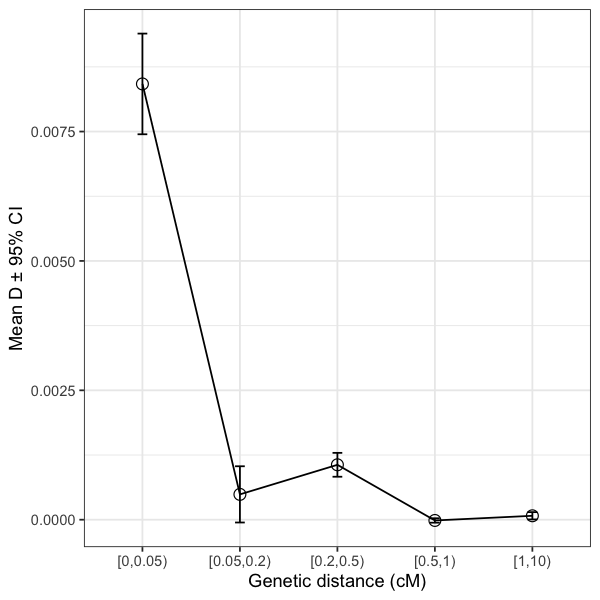

In [560]:
ci <- 0.95

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=gd.link, aes(x=gd_bin, y=D_mean, group=1)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(0.1))
p <- p + geom_line(position=position_dodge(0.1))
p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
                       width=0.1, position=position_dodge(0.1))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(betaA_pol_sign ~ betaB_pol_sign)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Variant annotation (both in pair)') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


In [561]:
maxAF <- 1

df.filt <- df[!is.na(df$gd_bin)
              & df$dafA<=maxAF & df$dafB<=maxAF,]

gd <- df.filt %>% 
    group_by(beta_align, gd_bin) %>%
    summarise(D_mean = mean(D_pol, na.rm = TRUE),
              D_stdev = sd(D_pol, na.rm = TRUE),
              D_stderr = sd(D_pol, na.rm = TRUE)/sqrt(length(D_pol[!is.na(D_pol)])),
              count = length(D_pol[!is.na(D_pol)])
             )
# gd

`summarise()` has grouped output by 'beta_align'. You can override using the `.groups` argument.



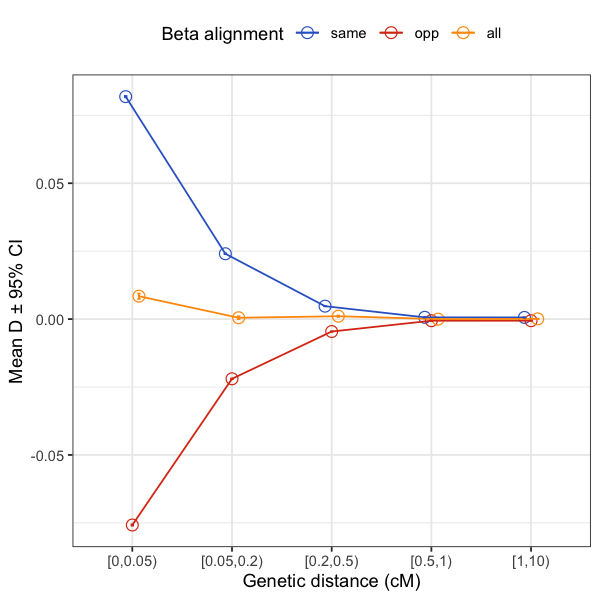

In [562]:
ci <- 0.95
dodge <- 0.2

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=dplyr::bind_rows(gd, gd.link), aes(x=gd_bin, y=(D_mean), group=beta_align, col=beta_align)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(dodge))
p <- p + geom_line(position=position_dodge(dodge))
p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
                       width=0.1, position=position_dodge(dodge))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(~ beta_align)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Beta alignment') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


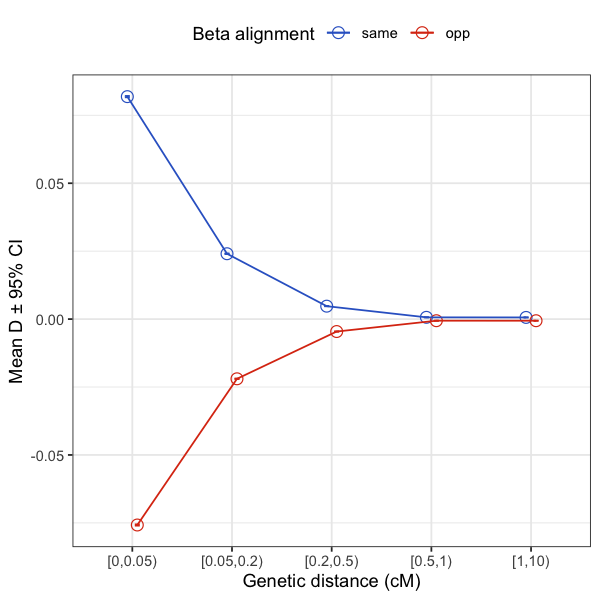

In [563]:
ci <- 0.95
dodge <- 0.2

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=gd, aes(x=gd_bin, y=(D_mean), group=beta_align, col=beta_align)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(dodge))
p <- p + geom_line(position=position_dodge(dodge))
p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
                       width=0.1, position=position_dodge(dodge))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(~ beta_align)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Beta alignment') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


#### Random polarization

##### D

In [564]:
maxAF <- 1
pVal_max <- 1e-10

df.filt <- df[!is.na(df$gd_bin)
              & df$pValA<=pVal_max
              & df$pValB<=pVal_max
              & df$dafA<=maxAF & df$dafB<=maxAF,]

gd.rand <- df.filt %>% 
    group_by(gd_bin) %>%
    summarise(D_mean = mean(D_pol_rand, na.rm = TRUE),
              D_stdev = sd(D_pol_rand, na.rm = TRUE),
              D_stderr = sd(D_pol_rand, na.rm = TRUE)/sqrt(length(D_pol_rand[!is.na(D_pol_rand)])),
              count = length(D_pol_rand[!is.na(D_pol_rand)])
             )
# gd

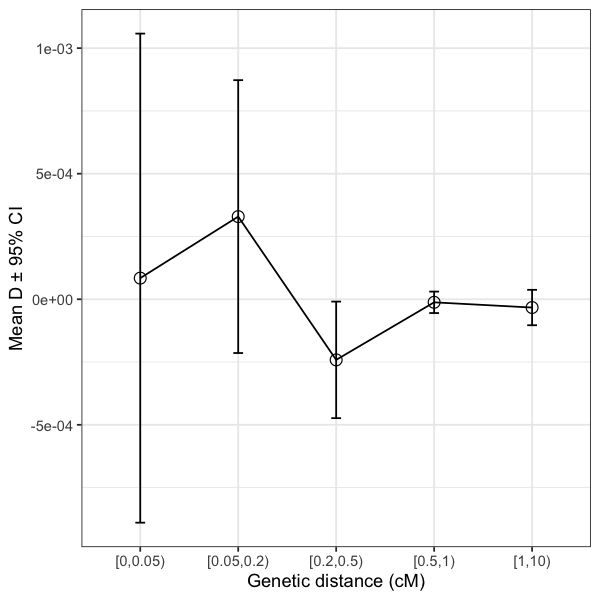

In [565]:
ci <- 0.95

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=gd.rand, aes(x=gd_bin, y=D_mean, group=1)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(0.1))
p <- p + geom_line(position=position_dodge(0.1))
p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
                       width=0.1, position=position_dodge(0.1))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(betaA_pol_sign ~ betaB_pol_sign)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Variant annotation (both in pair)') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


In [566]:
maxAF <- 1
pVal_max <- 1e-10

df.filt <- df[!is.na(df$gd_bin)
              & df$pValA<=pVal_max
              & df$pValB<=pVal_max
              & df$dafA<=maxAF & df$dafB<=maxAF,]

gd.rand <- df.filt %>% 
    group_by(beta_align_rand, gd_bin) %>%
    summarise(D_mean = mean(D_pol_rand, na.rm = TRUE),
              D_stdev = sd(D_pol_rand, na.rm = TRUE),
              D_stderr = sd(D_pol_rand, na.rm = TRUE)/sqrt(length(D_pol_rand[!is.na(D_pol_rand)])),
              count = length(D_pol_rand[!is.na(D_pol_rand)])
             )
# gd

`summarise()` has grouped output by 'beta_align_rand'. You can override using the `.groups` argument.



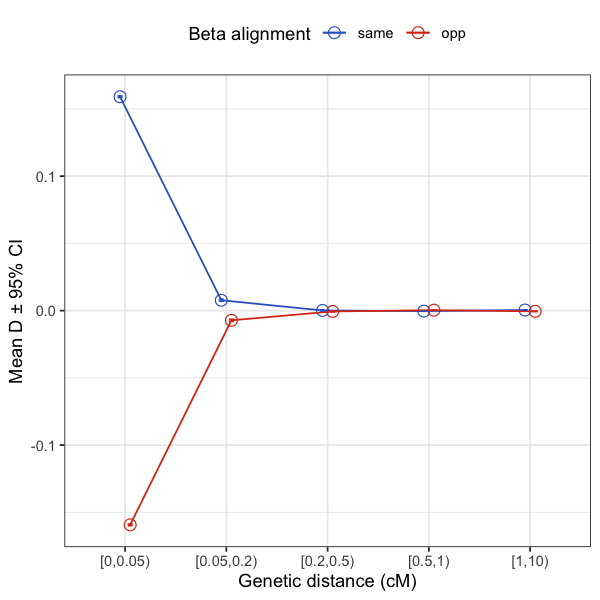

In [567]:
ci <- 0.95
dodge <- 0.2

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=gd.rand, aes(x=gd_bin, y=(D_mean), group=beta_align_rand, col=beta_align_rand)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(dodge))
p <- p + geom_line(position=position_dodge(dodge))
p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
                       width=0.1, position=position_dodge(dodge))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(~ beta_align)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Beta alignment') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


In [568]:
gd$diff <- gd$D_mean - gd.rand$D_mean

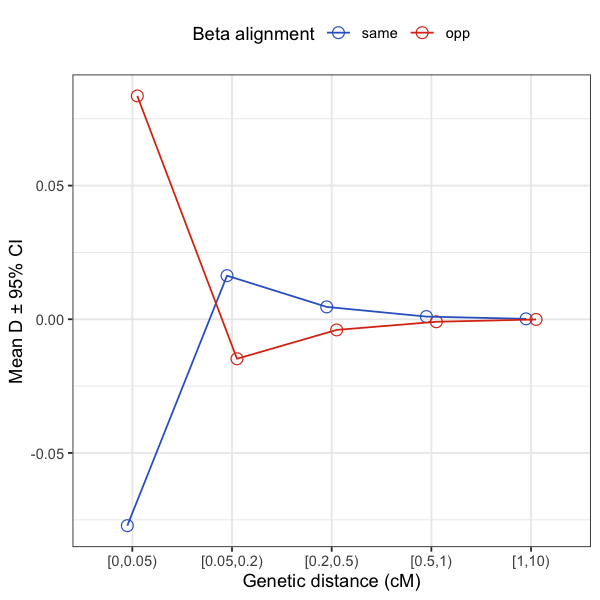

In [569]:
ci <- 0.95
dodge <- 0.2

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data=gd, aes(x=gd_bin, y=(diff), group=beta_align, col=beta_align)) + theme_bw() + scale_color_gdocs()
p <- p + geom_point(fill=NA, shape=21, size=3, position=position_dodge(dodge))
p <- p + geom_line(position=position_dodge(dodge))
# p <- p + geom_errorbar(aes(x=gd_bin, ymin=D_mean-D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
#                            ymax=D_mean+D_stderr*qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)),
#                        width=0.1, position=position_dodge(dodge))
# p <- p + geom_hline(yintercept = 0, linetype = 'dashed', color='gray')
# p <- p + facet_grid(~ beta_align)
p <- p + xlab('Genetic distance (cM)') + ylab('Mean D ± 95% CI')
p <- p + labs(color='Beta alignment') + theme(legend.position="top")
# p <- p + coord_cartesian(ylim=c(-1e-3, 1e-3))
# p <- p + geom_hline(data=gd, aes(yintercept=D_mean, col='D_mean'))
# p <- p + scale_y_log10()
plot(p)
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_vline(xintercept = -as.numeric(as.character(plot_sc)), linetype = 'dotted', color='red')
# p <- p + geom_point(aes(x=-sr, y=mean, col=is_dead), position=position_dodge(0.05))
# p <- p + geom_errorbar(aes(x = -sr, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),


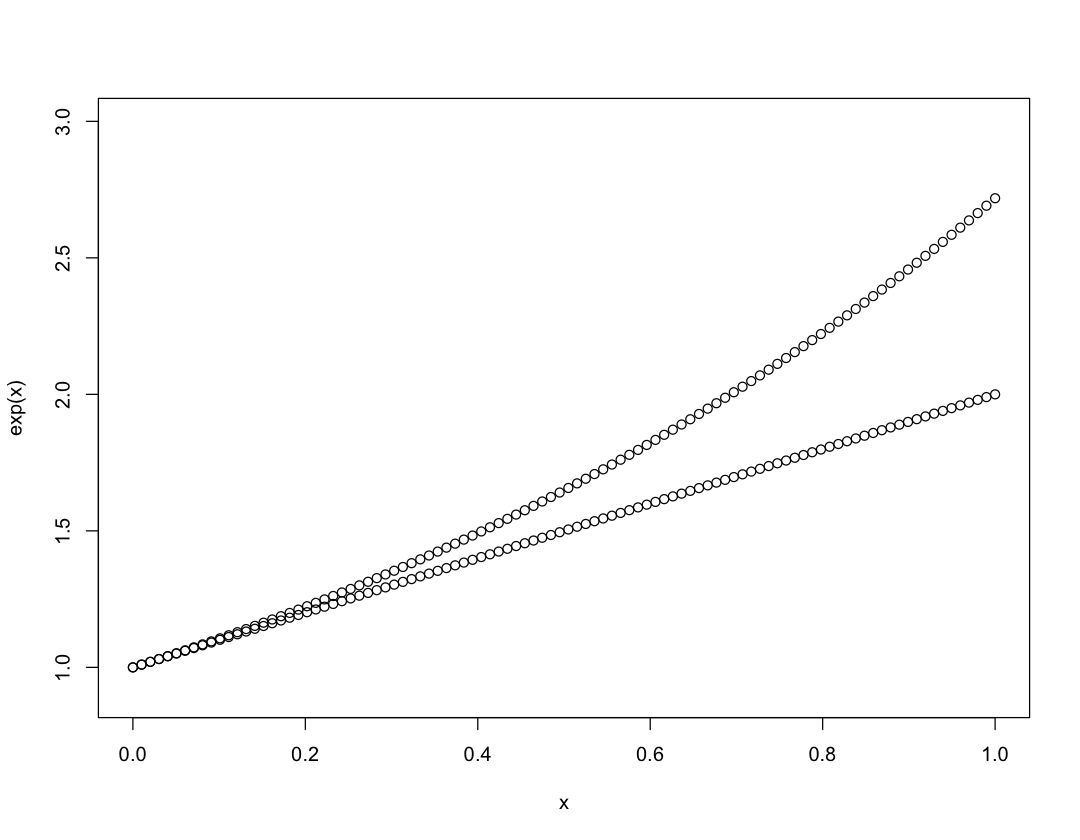

In [592]:
x <- seq(0,1,length=100)
plot(x, exp(x), ylim=c(0.9,3))
points(x, 1+x)

# Trashed drafts

## r01.1

no recombination

```bash

pwd
# /n/data2/bwh/genetics/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r01.1


```

```bash
RUN=r01.1
RECOMB=0
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=11-100%20 \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.txt.gz
```

##### Frequency cut

Compile summary stats

```bash
N=10000
MIN_FREQ=0.05

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

### R session

In [5]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r01.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [6]:
dat <- read.table('summary_stats_type.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [8]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.


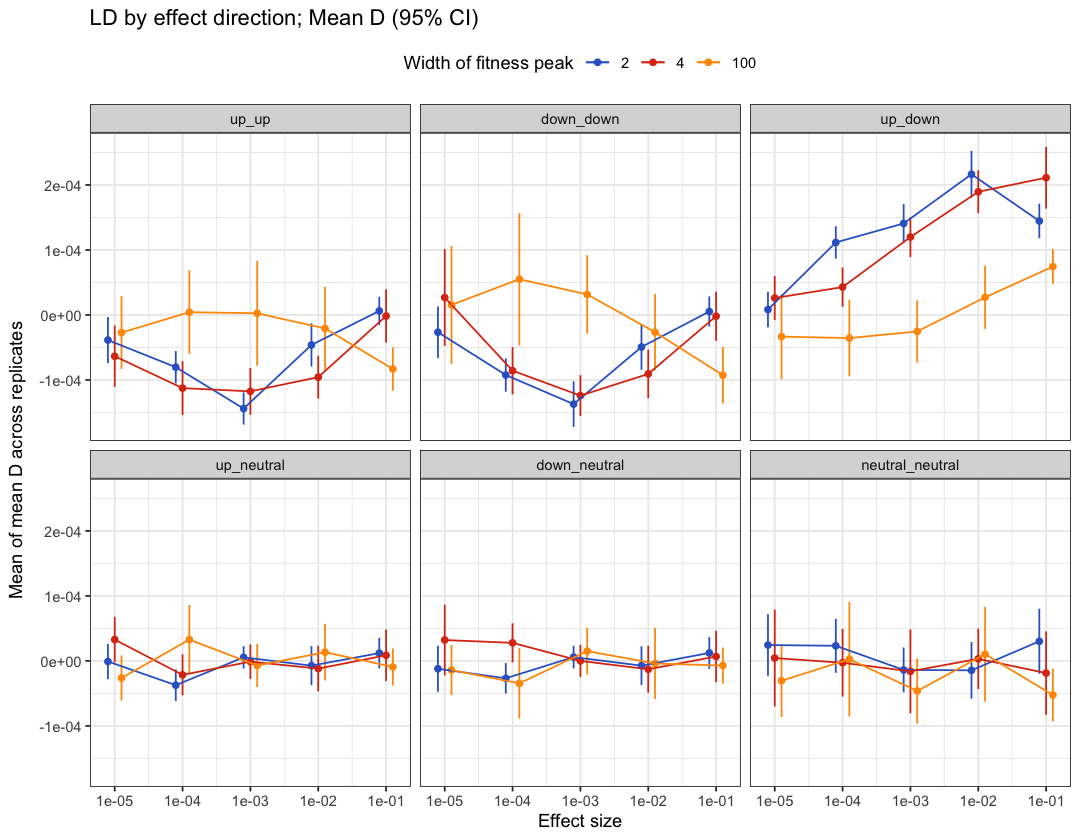

In [9]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### Add frequency cut

In [577]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r01.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [578]:
dat <- read.table('summary_stats_type.min_frq_0.05.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [579]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat.filt <- dat

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.



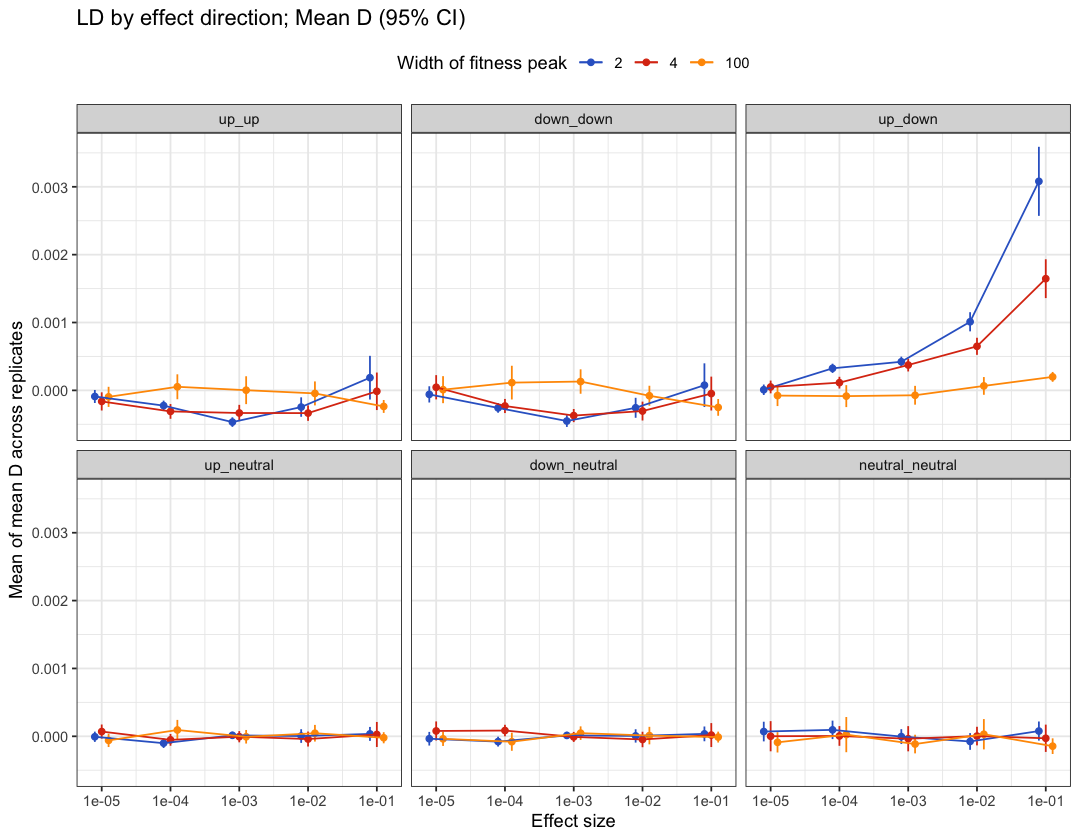

In [580]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

## r01.2

recombination of 1e-6

```bash
pwd
# /n/data2/bwh/genetics/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r01.2
```

```bash
RUN=r01.2
RECOMB=1e-6
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=1-80%20 \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.txt.gz
```

### R session

In [149]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r01.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [150]:
dat <- read.table('summary_stats_type.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [151]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.



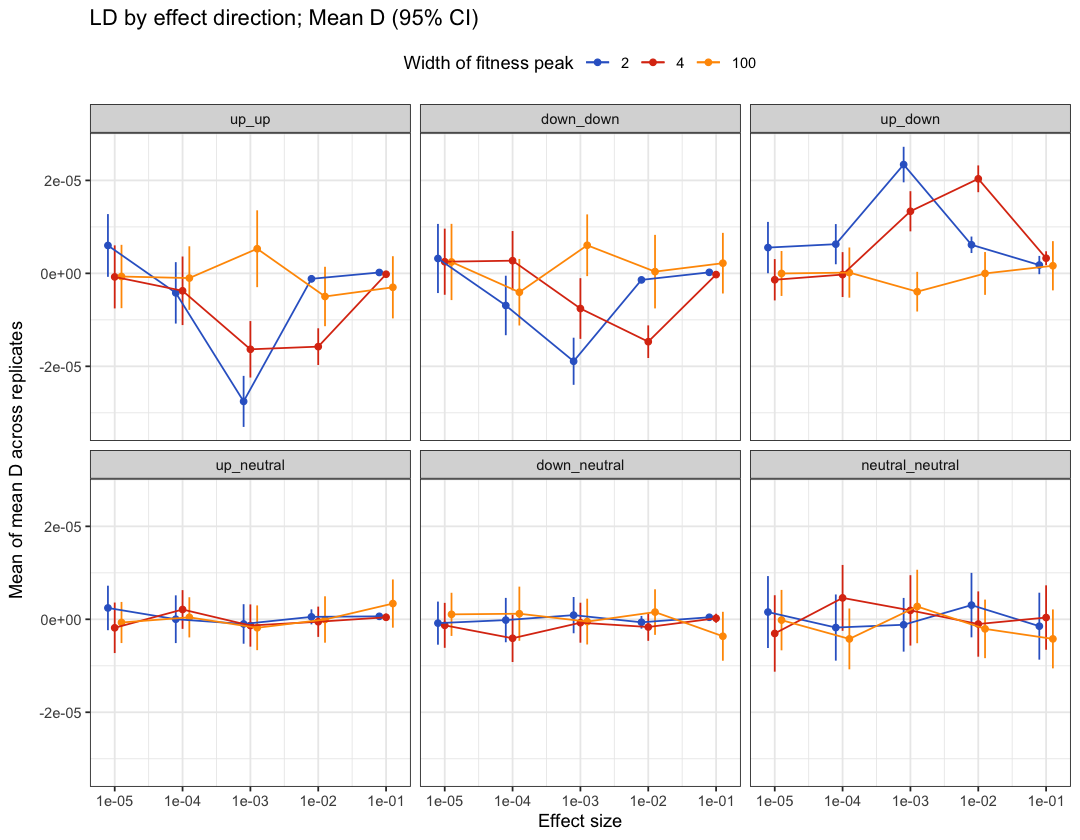

In [148]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

## r01.3

recombination 1e-8

```bash
pwd
# /n/data2/bwh/genetics/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r01.3
```

```bash
RUN=r01.3
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=1-100%20 \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.txt.gz
```

### R session

In [153]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r01.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [154]:
dat <- read.table('summary_stats_type.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [155]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.



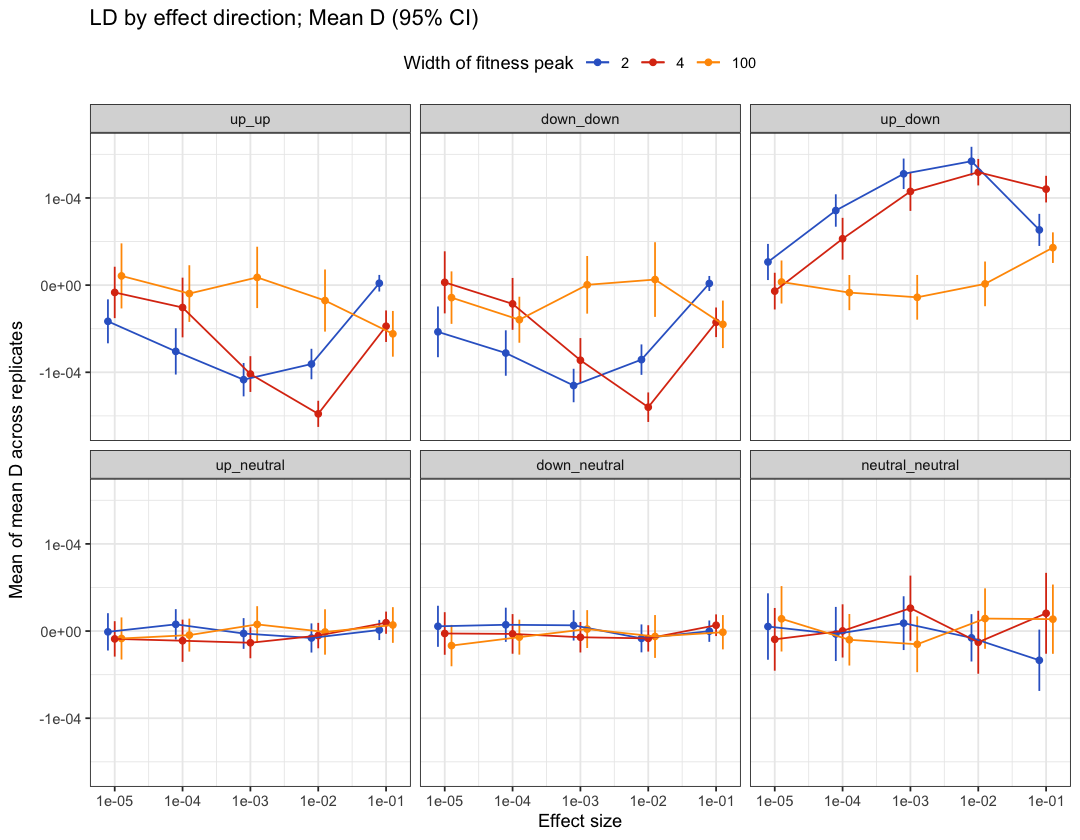

In [156]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

## r01.4

no recombination

high mutation rate $\mu = 1e-7$

```bash
pwd
# /n/data2/bwh/genetics/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r01.4
```

```bash
RUN=r01.4
RECOMB=0
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-7

mkdir -p log
for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=1-100%20 \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 100
do
    for EFFECT in 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.txt.gz
```

### R session

In [222]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r01.4')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [223]:
dat <- read.table('summary_stats_type.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [224]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.



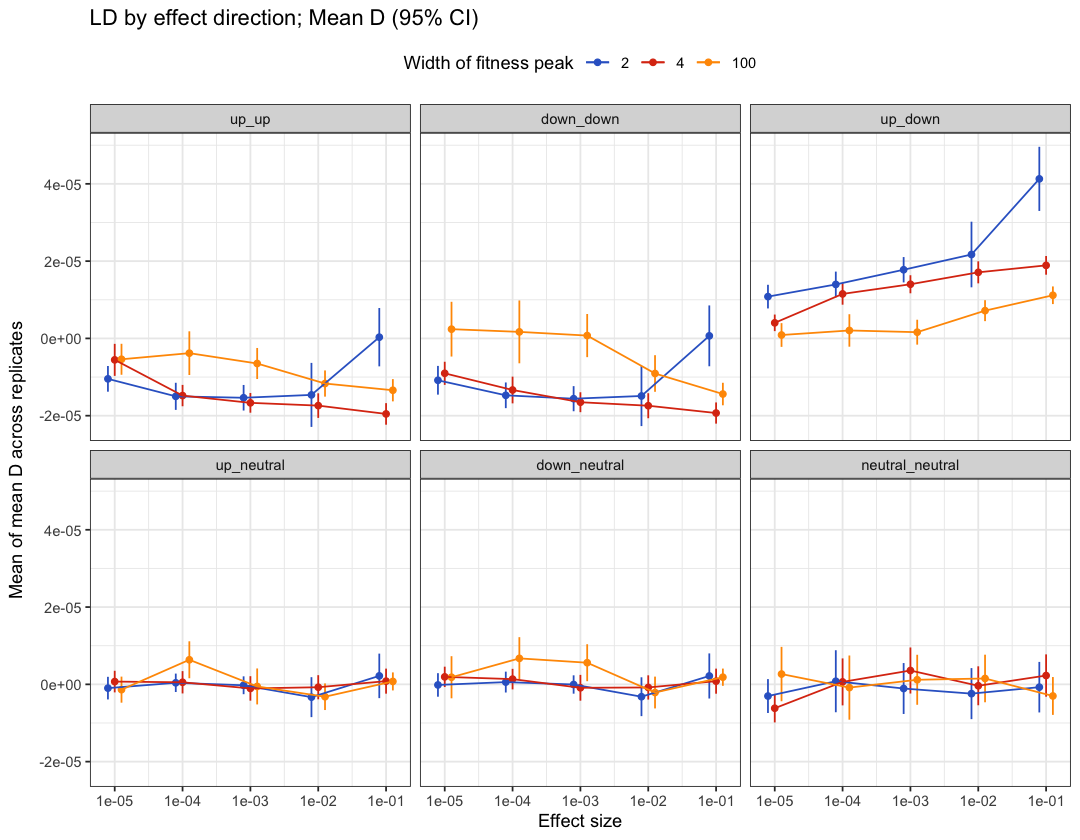

In [225]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

## r02.1

no recombination

Might have made a mistake in the fitness calculation?

i think it should be
```
   inds.fitnessScaling = exp(-a^2 * (up_mut - down_mut)^2 / (2 * w^2));
```

previously a wasn't getting squared (although I guess this just underscales the effect size by the square

```bash

pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r02.1


```

```bash
RUN=r02.1
RECOMB=0
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 1000
do
    for EFFECT in 1e0 1e-1 1e-2 1e-3 1e-4
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=1-20%50 \
            -c 1 \
            -t 0-01:00 \
            --mem=60 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-01:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

### R session

In [25]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r02.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [28]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [29]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.


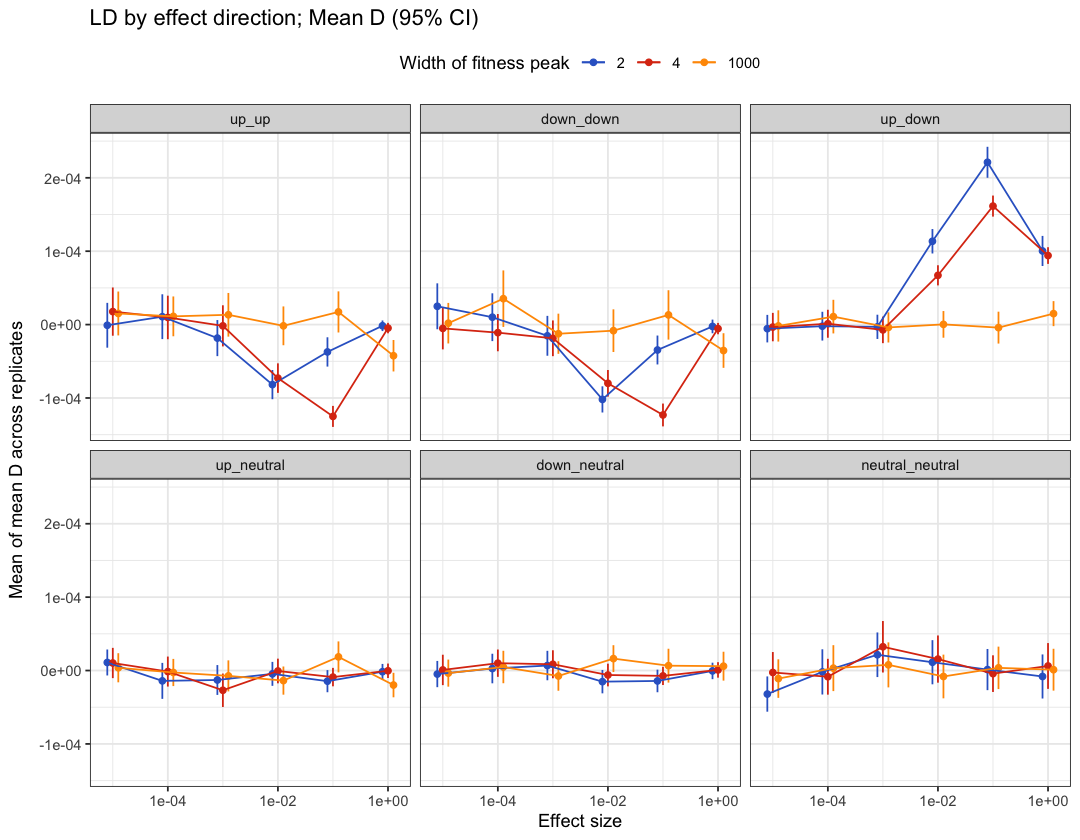

In [33]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all" & dat_summary$effect < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

### LD-spec

Thus far we've been using $D$ as our metric. Now, let's switch to the $\xi$ metric used in [Schoech 2020](http://biorxiv.org/lookup/doi/10.1101/2020.09.23.310748).

$$
\xi_k = \frac{\sum_{(i,j) \in \mathscr{G}_k} \mathrm{Cov}(\beta_i, \beta_j)}
    {\sum_{(i,j) \in \mathscr{G}_k} \sqrt{\mathrm{Var}(\beta_i)\mathrm{Var}(\beta_j)}}
$$

## r02.2

How does this compare to HR effect alone? we can test this by running a simulation with unidirectional effect size (i.e. down-only or up-only) to find where HR occurs

```bash

pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r02.2


```

```bash
RUN=r02.2
RECOMB=0
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=301-500%50 \
            -c 1 \
            -t 0-00:30 \
            --mem=60 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-01:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

### R session

In [50]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r02.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [51]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up",
                            "down_down",
                            "up_down",
                            "up_neutral",
                            "down_neutral",
                            "neutral_neutral",
                            "all"))

In [52]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.


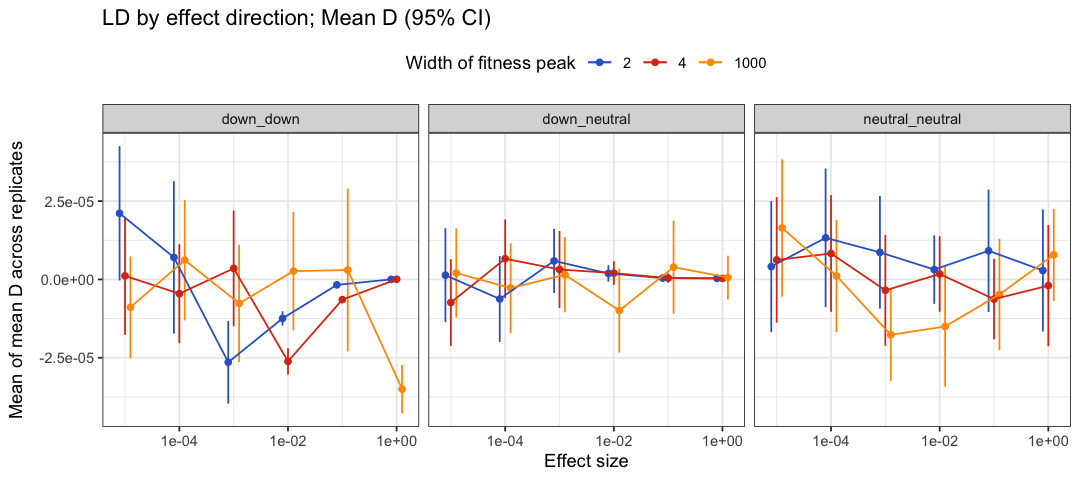

In [53]:
options(repr.plot.width=9, repr.plot.height=4)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type %in% c("down_down", "down_neutral", "neutral_neutral")
                             & dat_summary$effect < 10,
                            ], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean of mean D across replicates')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

## r03.1

no recombination

Might have made a mistake in the fitness calculation?

i think it should be
```
   inds.fitnessScaling = exp(-a^2 * (up_mut - down_mut)^2 / (2 * w^2));
```

previously a wasn't getting squared (although I guess this just underscales the effect size by the square

```bash

pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r03.1


```

```bash
RUN=r03.1
RECOMB=0
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
GEN=$(( N*10 ))
MU=1e-8

mkdir -p log
for WIDTH in 2 4 1000
do
#    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
   for EFFECT in 1e1 1e0
   do
        OUTDIR=w${WIDTH}/e${EFFECT}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, EFFECT ${EFFECT}
        sbatch \
            --array=201-520%50 \
            -c 1 \
            -t 0-01:00 \
            --mem=60 \
            -p short \
            -J $RUN.w${WIDTH}.e${EFFECT} \
            -o log/$RUN.w${WIDTH}.e${EFFECT}.%a.out \
            ./submit_array.sh \
                -N ${N} -g ${GEN} -R ${REG_SIZE} -w ${WIDTH} -a ${EFFECT} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        sbatch \
            -c 1 \
            -t 0-01:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.e${EFFECT} \
            -o log/st.$RUN.w${WIDTH}.e${EFFECT}.%A.out \
            ./summarize_type.sh $WIDTH $EFFECT $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for WIDTH in 2 4 1000
do
    for EFFECT in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
    do
        cat w${WIDTH}/e${EFFECT}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

## r04.1

note: this one uses argument variables for the slim script, rather than regenerating each time

this is pretty much the same as `r02.1` except there is recombination

### Batch run

```bash
RUN=r04.1
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-600%20 \
            -c 1 \
            -t 0-01:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

```bash
RUN=r04.1
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e-5
do
    for WIDTH in 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-600%20 \
            -c 1 \
            -t 0-00:30 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [139]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [140]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [141]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.


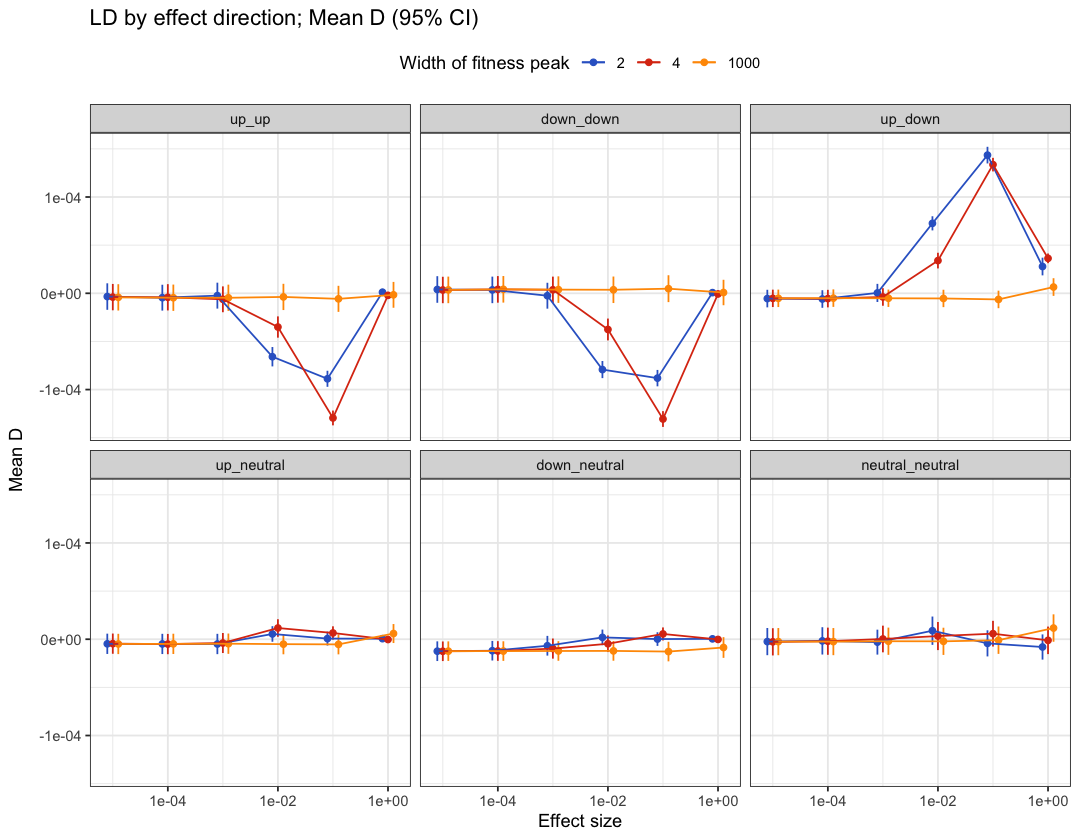

In [142]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all" & dat_summary$effect < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [143]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [144]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [145]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'effect'. You can override using the `.groups` argument.


pdf 
  2

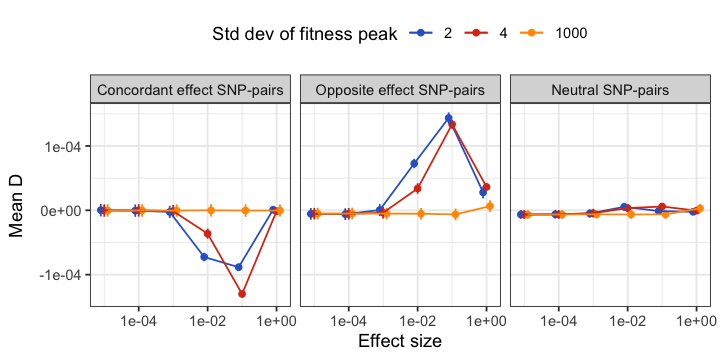

In [146]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" & dat_summary$effect < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [147]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [148]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [149]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [150]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

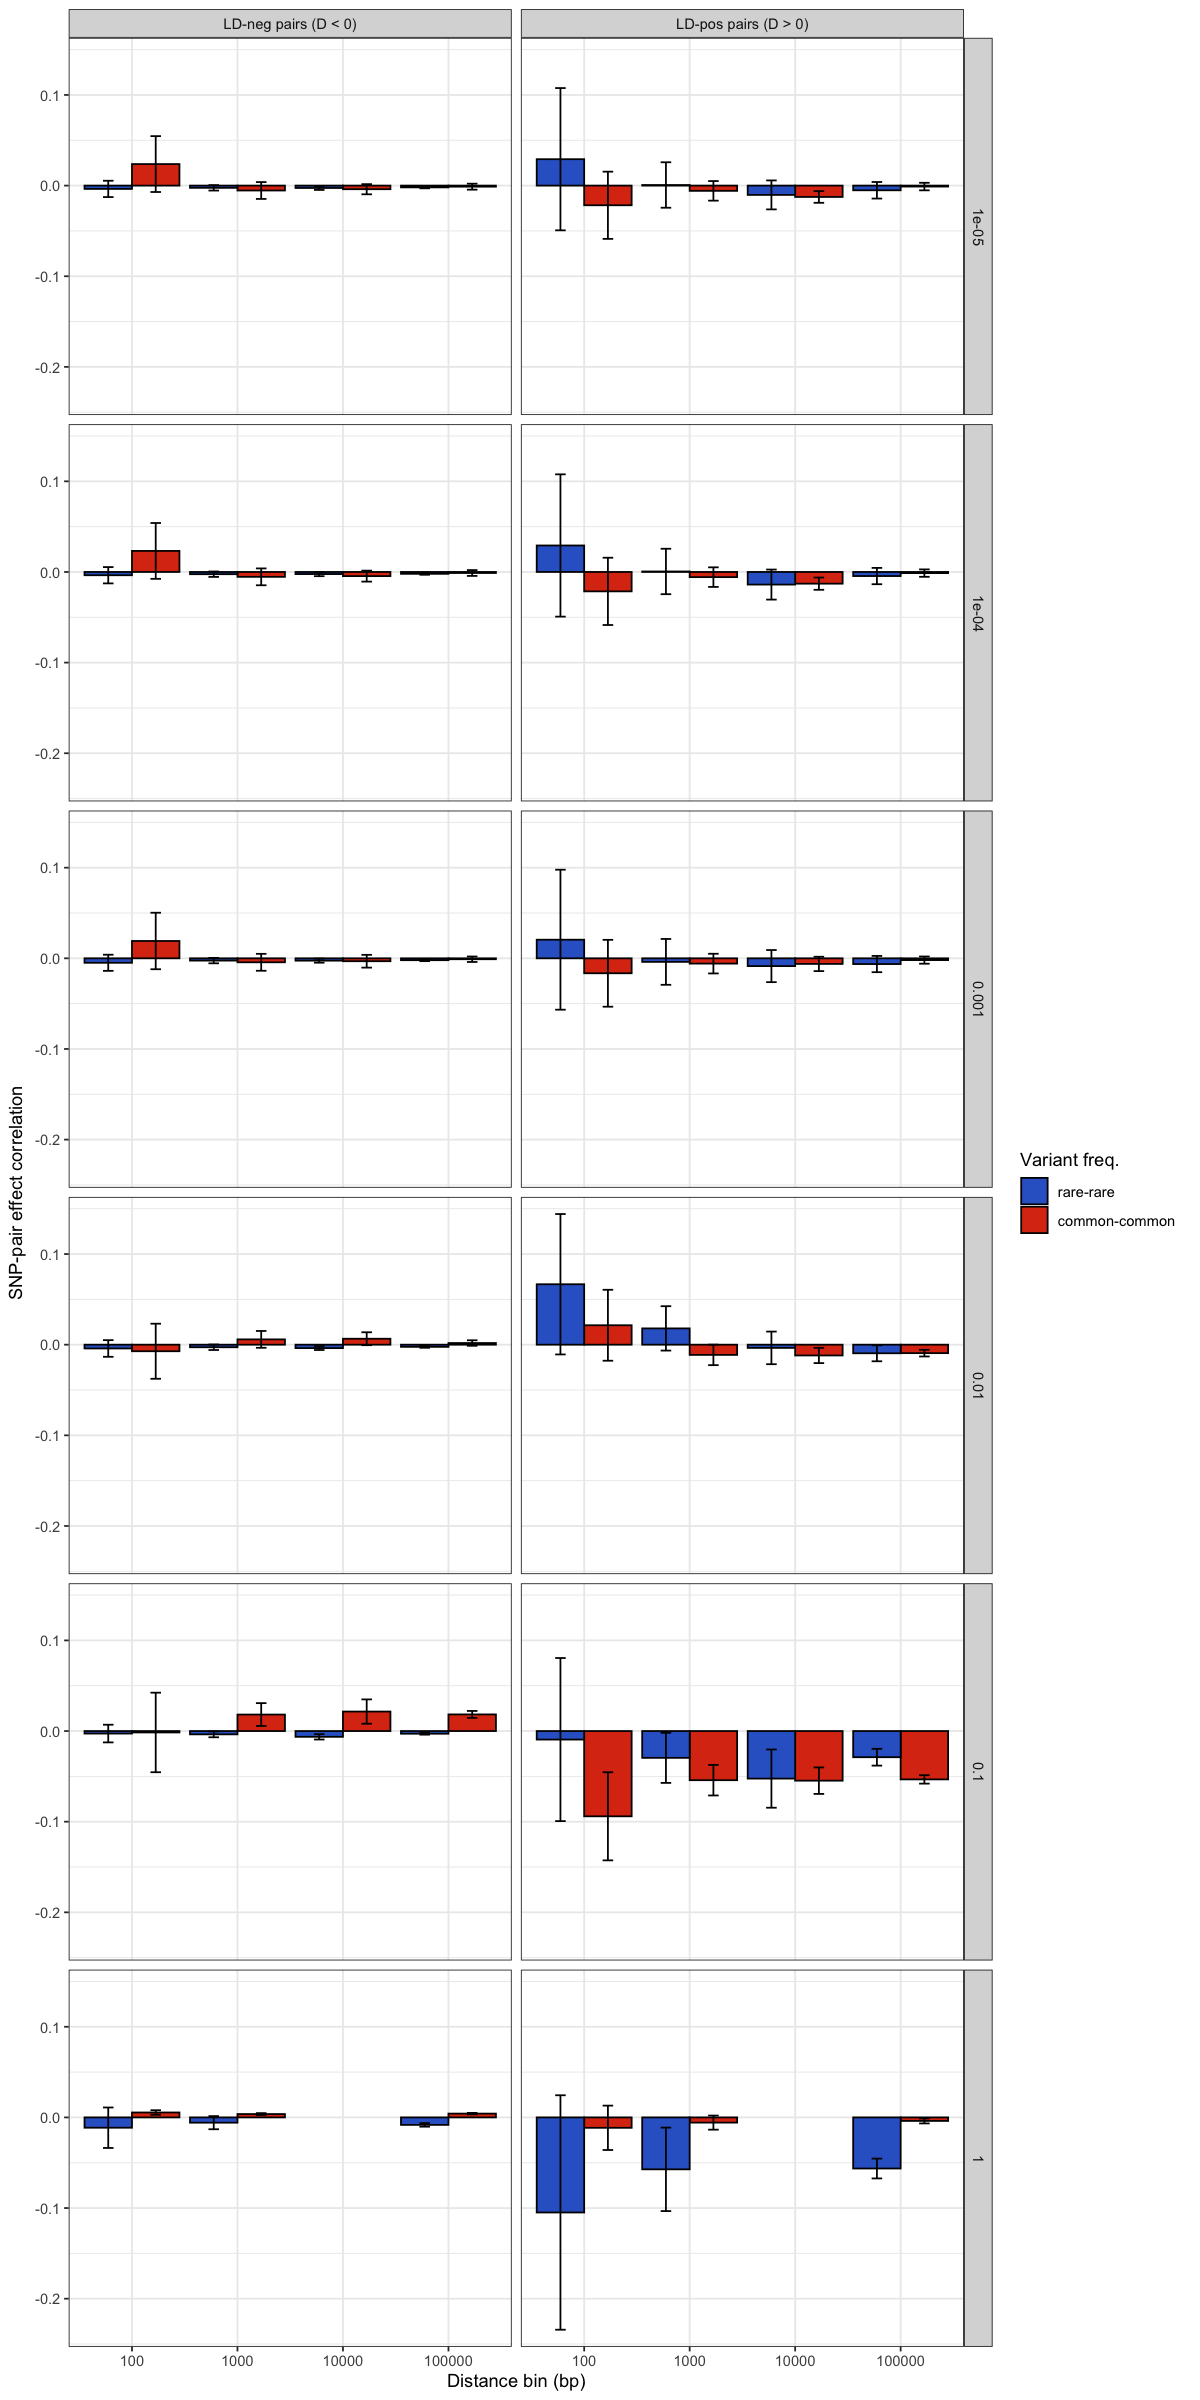

In [151]:
# w <- 6
# h <- 2.5

w <- 10
h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta<10,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))

p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w4_beta1e-1.pdf', h=h, w=w)
# print(p)
# dev.off()

pdf 
  2

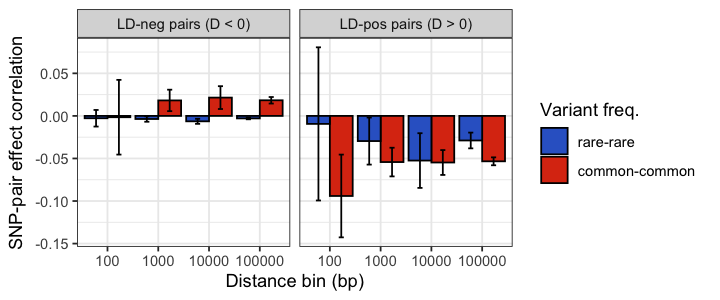

In [152]:
w <- 6
h <- 2.5

# w <- 10
# h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(.  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))

p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w4_beta1e-1.pdf', h=h, w=w)
print(p)
dev.off()

```bash

slim \
    -s 10000 \
    -d reg_length=100000 \
    -d dom_coeff=0.5 \
    -d recomb_rate=0 \
    -d mu=1e-8 \
    -d pop_size=10000 \
    -d width=2 \
    -d beta=-1e-1 \
    -d "out_prefix='test'" \
    1.slim_cmd.slim
```

```bash
time slim -d seed=1000 -d sd=2 -d "out_prefix='test1'" gravel_stabilizing_selection.slim
# real	22m15.183s
# user	22m8.412s
# sys	0m6.390s

time ./parse_vcf_gravel.py test1.vcf
# real	1m7.498s
# user	1m7.107s
# sys	0m0.255s
```

```bash
cat this.sh
# #!/usr/bin/bash

# time slim -d seed=1000 -d sd=2 -d "out_prefix='test2'" gravel_stabilizing_selection.slim

sbatch \
    -c 1 \
    -t 0-02:00 \
    -p short \
    --mem=4g \
    -J test \
    -o log.out \
    ./this.sh

```

## r04.1a, subsample population of N=1000

Using population demographic model (r04.2 and subsequent), cannot assess the entire population because there are too many variants in the gene pool. Therefore, I'm forced to subset a population of N=1000 in the final step for computational tractibility

I want to ensure that this doesn't introduct artifacts into the data, so I'm going to subset the VCFs generated in r04.1 to sample a population N=1000, and check that this still looks the same.

### Batch run

```bash
pwd
# /n/data2/hms/dbmi/sunyaev/lab/cchiang/expts/stabilizing_sim_2021-09-28/r04.1a
```

```bash
RUN=r04.1a
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
DS=1000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-500%20 \
            -c 1 \
            -t 0-00:20 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_ds_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -D ${DS} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=1000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
#    for WIDTH in 2 1000 4
    for WIDTH in 1000
    do
        sbatch \
            -c 1 \
            -t 0-08:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

In [76]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1a')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

#### Detailed LD fig

In [77]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [78]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


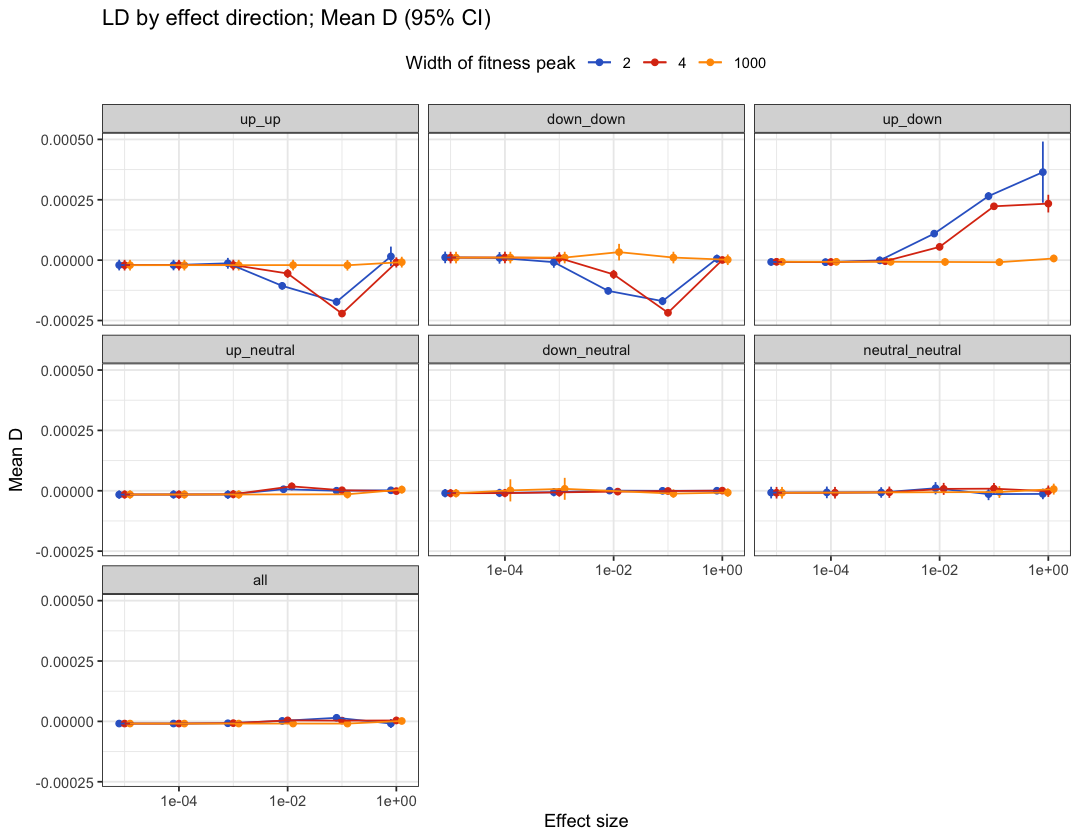

In [79]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [80]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1a')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [81]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [82]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

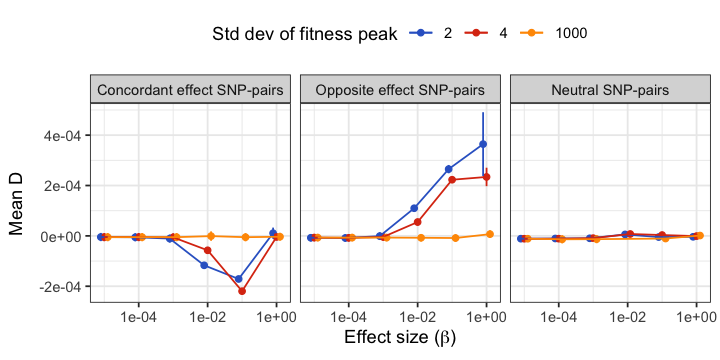

In [83]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" & dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [113]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1a')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [114]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [115]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [116]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

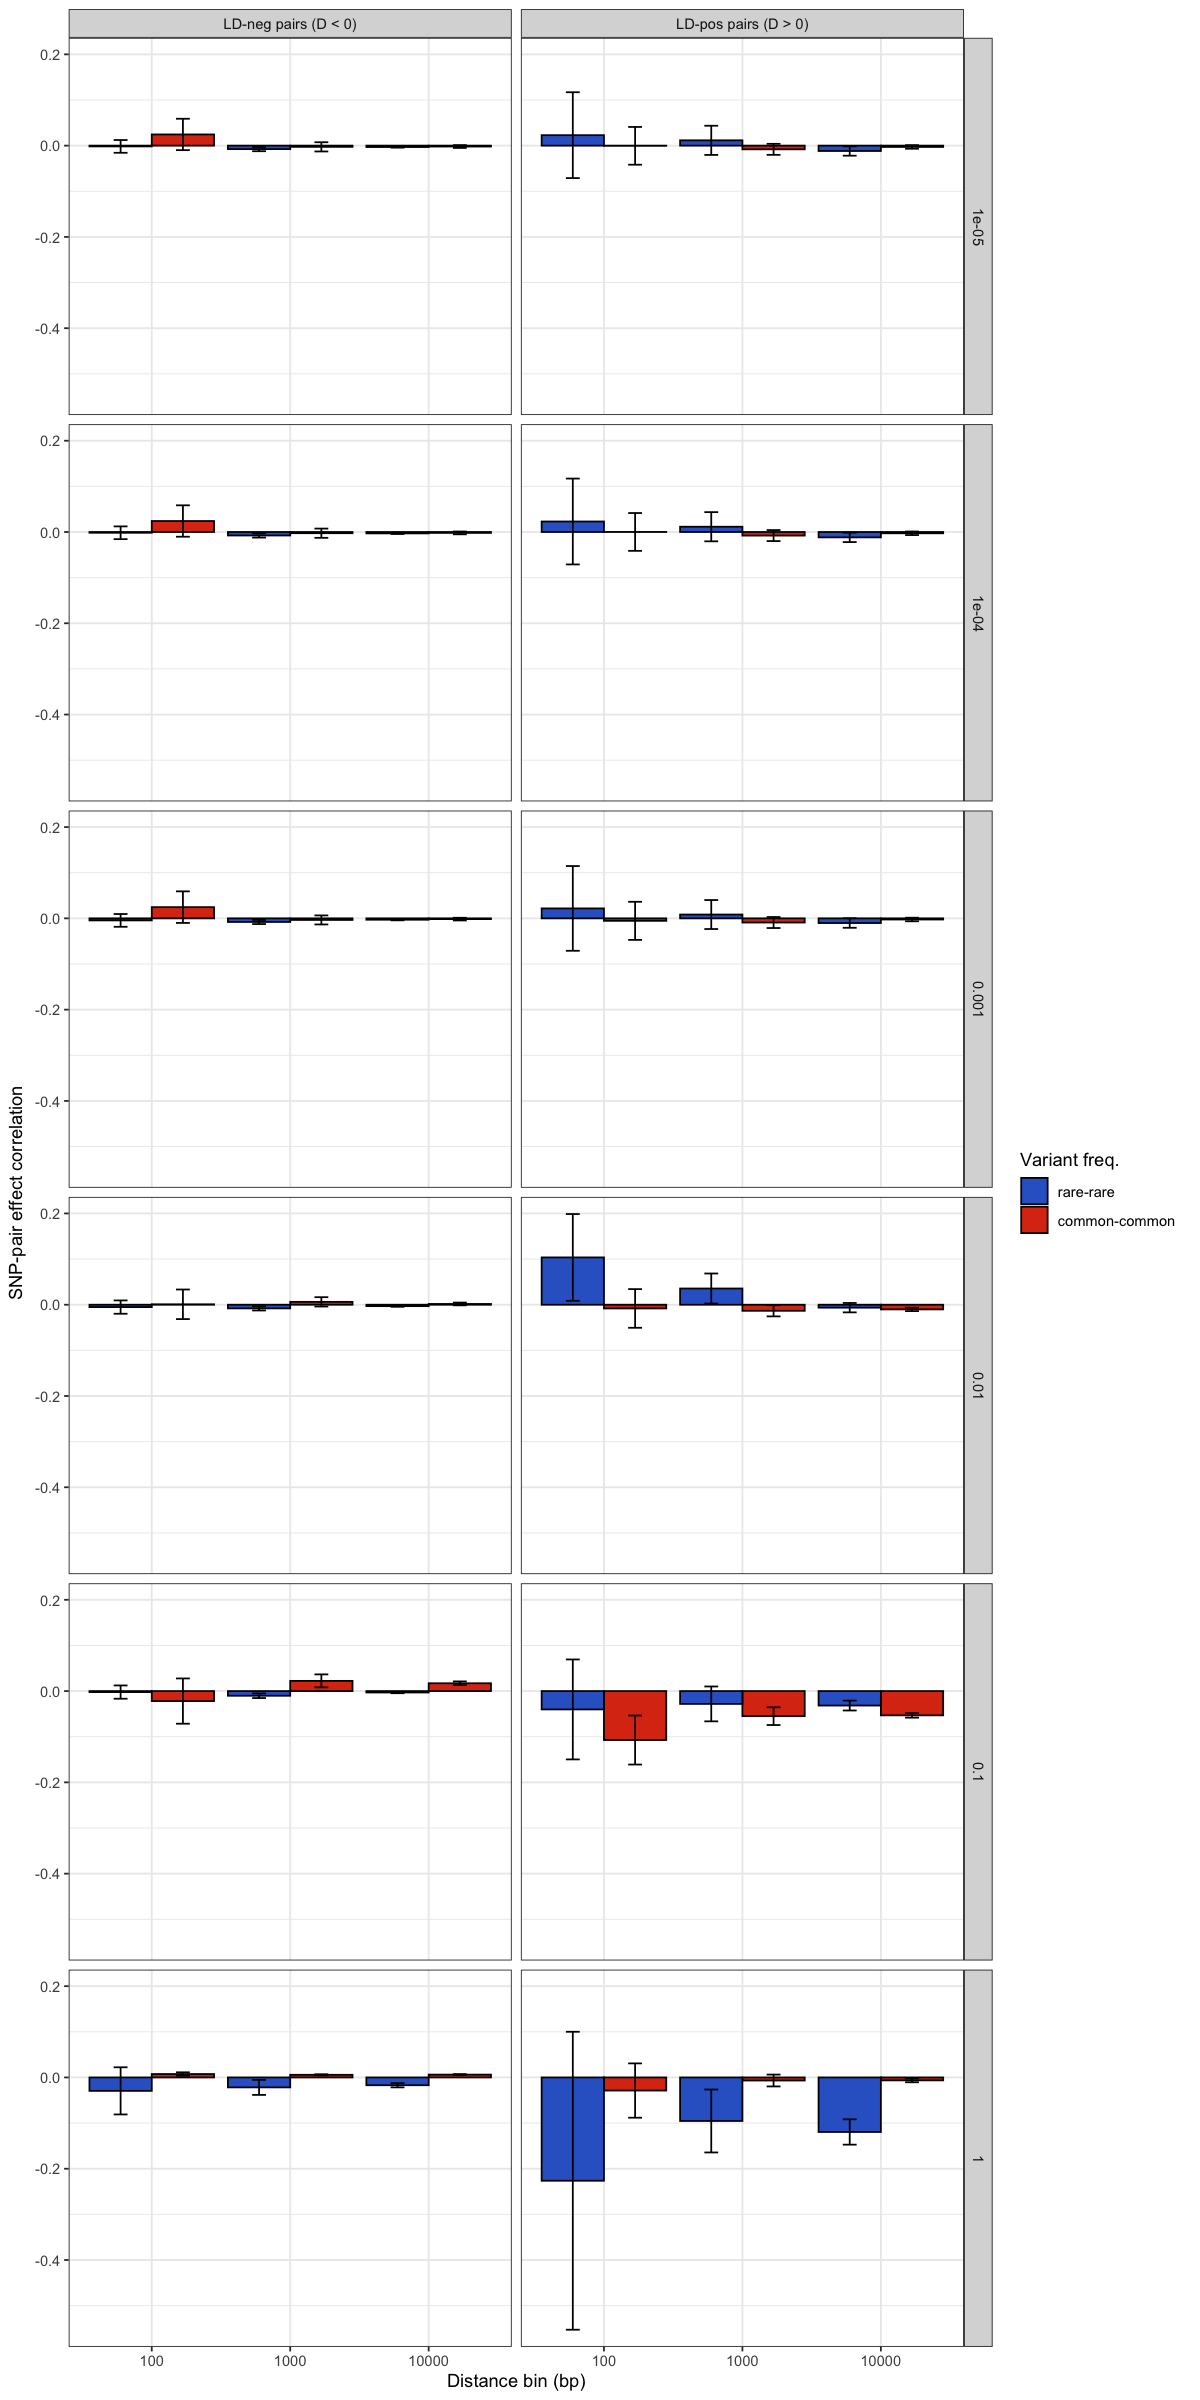

In [117]:
# w <- 6
# h <- 2.5

w <- 10
h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta<10,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))

p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w4_beta1e-1.pdf', h=h, w=w)
# print(p)
# dev.off()

pdf 
  2

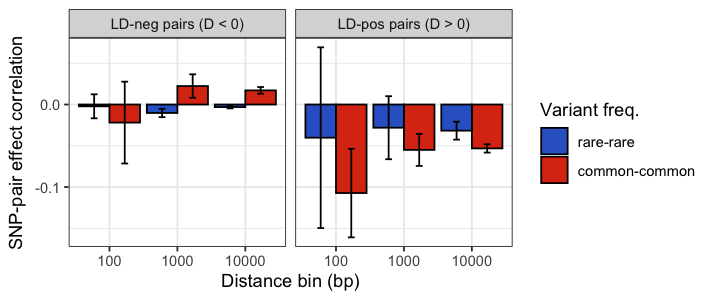

In [118]:
w <- 6
h <- 2.5

# w <- 10
# h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(.  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))

p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w4_beta1e-1.pdf', h=h, w=w)
print(p)
dev.off()

## r04.2

this is pretty much the same as `r04.1` except
 - uses Gravel model rather than static N=1000 population

There are too many SNPS to sample at the end, so now just sampling 1000 individuals from European population
(see `r04.1a` which checks that this downsampling doesn't introduce bias)

### Individual command

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -d seed=10 \
    -d sample_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Batch run

```bash
RUN=r04.2
N=1000

mkdir -p log
# for BETA in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
for BETA in 1e1
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1501-1700%20 \
            -c 1 \
            -t 0-00:40 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -w ${WIDTH} -b ${BETA} -o $OUTDIR
    done
done
```

```bash
RUN=r04.2
N=1000

mkdir -p log
# for BETA in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
for BETA in 1e1
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-500%20 \
            -c 1 \
            -t 0-00:40 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -w ${WIDTH} -b ${BETA} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=1000
MIN_FREQ=0

for BETA in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-08:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep st | grep PENDING | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for BETA in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e1 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

```
          13584488     short    cc514 COMPLETE    3:00:58   4:00:00      1 compute-a-16-162 st.r04.2.w2.b1e-5
          13584489     short    cc514 COMPLETE    2:58:42   4:00:00      1 compute-a-16-162 st.r04.2.w1000000.b1e-5
          13584490     short    cc514 COMPLETE    2:58:28   4:00:00      1 compute-a-16-162 st.r04.2.w4.b1e-5
          13584486     short    cc514 COMPLETE    2:39:42   4:00:00      1 compute-e-16-181 st.r04.2.w4.b1e-4
          13584482     short    cc514 COMPLETE    3:03:41   4:00:00      1 compute-a-16-162 st.r04.2.w1000000.b1e-3
          13584483     short    cc514 COMPLETE    3:06:25   4:00:00      1 compute-a-16-162 st.r04.2.w4.b1e-3
          13584484     short    cc514 COMPLETE    3:03:28   4:00:00      1 compute-a-16-162 st.r04.2.w2.b1e-4
          13584485     short    cc514 COMPLETE    3:02:44   4:00:00      1 compute-a-16-162 st.r04.2.w1000000.b1e-4
          13584473     short    cc514 COMPLETE    3:25:20   4:00:00      1 compute-e-16-180 st.r04.2.w1000000.b1e0
          13584476     short    cc514 COMPLETE    3:28:22   4:00:00      1 compute-e-16-180 st.r04.2.w1000000.b1e-1
          13584477     short    cc514 COMPLETE    2:45:51   4:00:00      1 compute-e-16-180 st.r04.2.w4.b1e-1
          13584478     short    cc514 COMPLETE    3:17:02   4:00:00      1 compute-e-16-180 st.r04.2.w2.b1e-2
          13584479     short    cc514  RUNNING    3:28:29   4:00:00      1 compute-a-16-162 st.r04.2.w1000000.b1e-2
          13584480     short    cc514  RUNNING    3:28:29   4:00:00      1 compute-a-16-162 st.r04.2.w4.b1e-2
          13584481     short    cc514  RUNNING    3:28:29   4:00:00      1 compute-a-16-162 st.r04.2.w2.b1e-3
```

### Figures

#### Fitness paradigm

In [35]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

##### Stabilizing

In [21]:
x <- seq(-7,7, length=1000)

sigma <- 2
d1 <- data.frame(x=x, fitness=exp(-x^2/(2*sigma^2)), width=as.factor(sigma))

sigma <- 4
d2 <- data.frame(x=x, fitness=exp(-x^2/(2*sigma^2)), width=as.factor(sigma))

sigma <- 1e6
d3 <- data.frame(x=x, fitness=exp(-x^2/(2*sigma^2)), width=as.factor(sigma))

# bind together
dat <- rbind(d1, d2, d3)

pdf 
  2

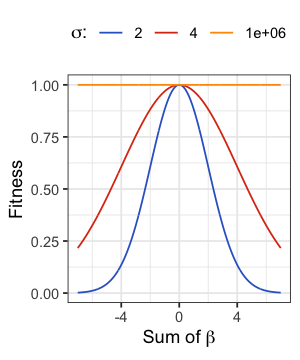

In [22]:
h <- 3
w <- 2.5
options(repr.plot.width=w, repr.plot.height=h)

p <- ggplot(data=dat, aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_point(aes(x=x, y=fitness))
p <- p + geom_line(aes(x=x, y=fitness))
p <- p + xlab(expression(paste("Sum of ", beta))) + ylab('Fitness')
p <- p + labs(color=expression(paste(sigma, ":"))) + theme(legend.position="top")
print(p)

pdf('figs/stabilizing_fitness_paradigm.pdf', h=h, w=w)
print(p)
dev.off()

#### Detailed LD fig

In [36]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [37]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


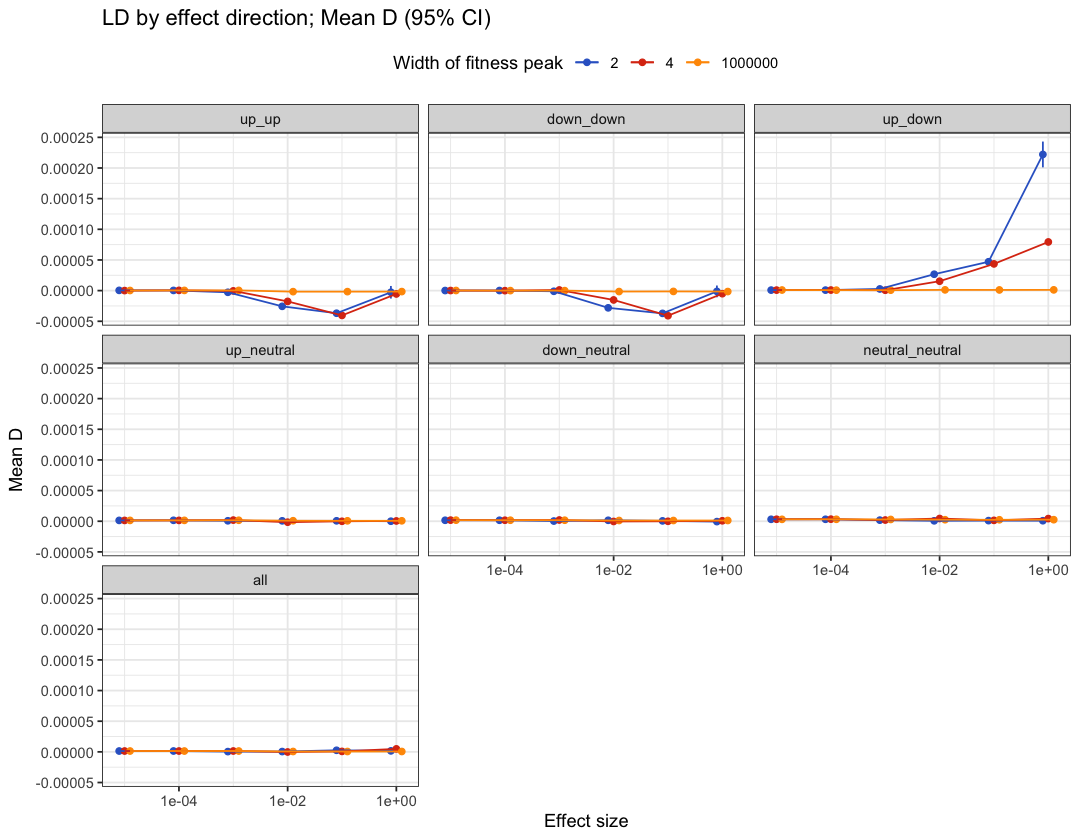

In [38]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [39]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [40]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [41]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

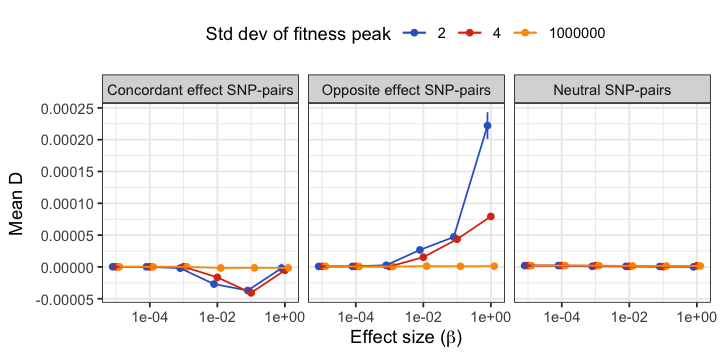

In [42]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" & dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [43]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.2')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [44]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [45]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [46]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

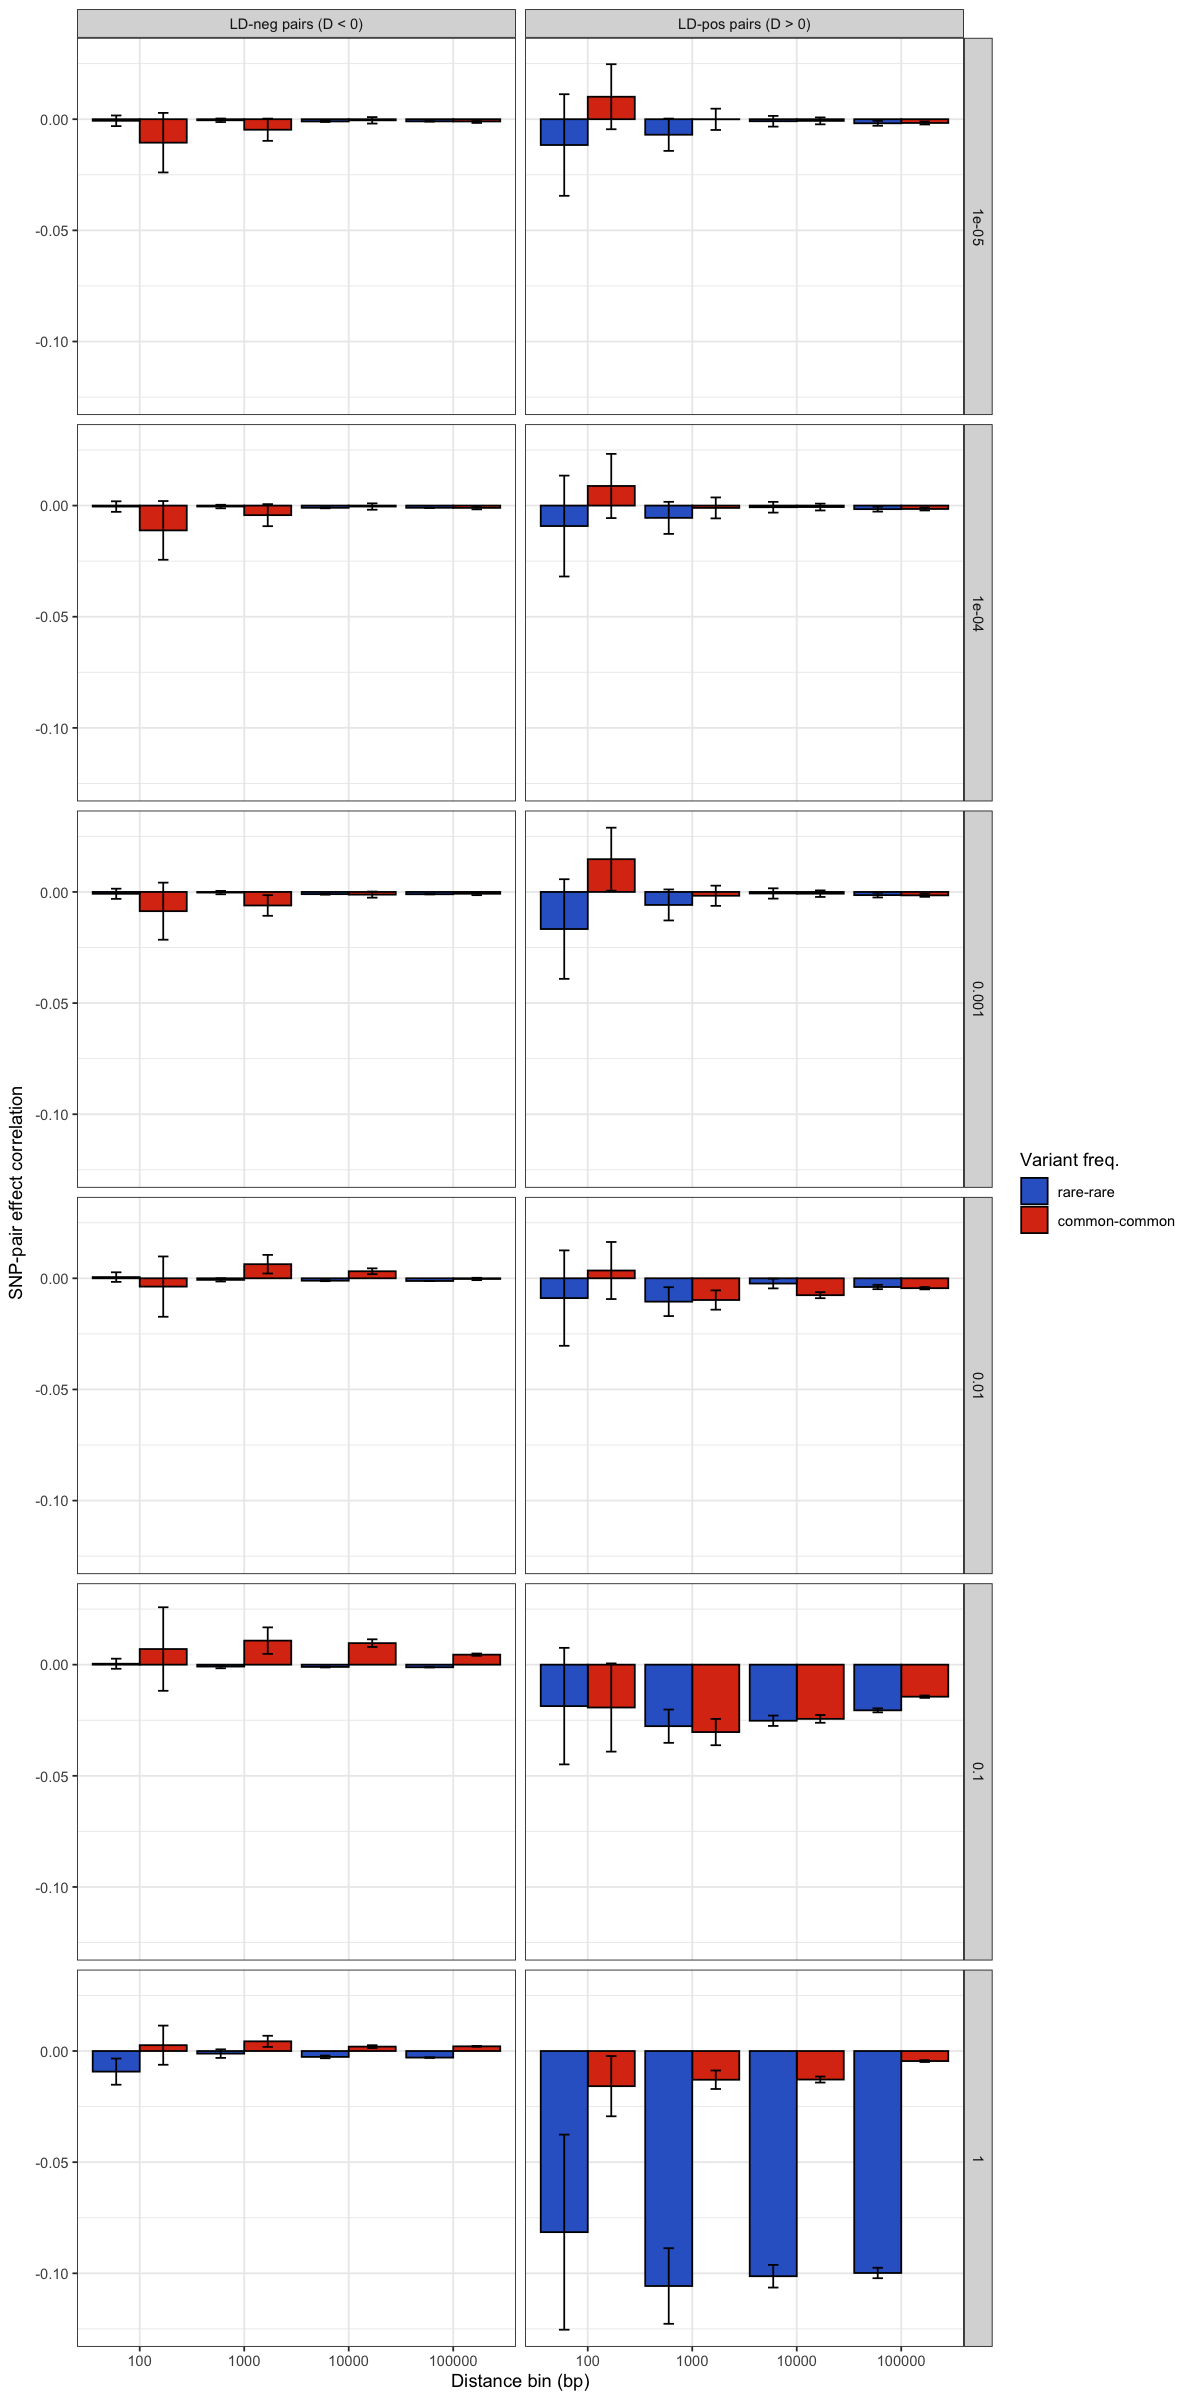

In [47]:
# w <- 6
# h <- 2.5

w <- 10
h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta<10,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
# p <- p + facet_grid(.  ~ corr_class,
#                     labeller = labeller(corr_class = corr_class.labs))

p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w4_beta1e-1.pdf', h=h, w=w)
# print(p)
# dev.off()

## r04.3

Simulation of directional selection

### Individual command

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -d seed=10 \
    -d sample_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Batch run

```bash
RUN=r04.3
N=1000

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1-200%20 \
            -c 1 \
            -t 0-00:40 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -w ${WIDTH} -b ${BETA} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=1000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-04:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep st | grep PENDING | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Fitness paradigm

In [1]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.3')

In [2]:
library('ggplot2')
library('ggthemes')

##### Directional, additive

In [3]:
beta <- 0.1

In [4]:
x <- seq(-7,7, length=100)

sigma <- 2
s <- -beta * (exp(-1^2/(2*sigma^2)) - 1)
d <- 1 + x * s
d1 <- data.frame(x=x, fitness=sapply(d, function(x){return(min(x, 1))}), width=as.factor(sigma))

sigma <- 4
s <- -beta * (exp(-1^2/(2*sigma^2)) - 1)
d <- 1 + x * s
d2 <- data.frame(x=x, fitness=sapply(d, function(x){return(min(x, 1))}), width=as.factor(sigma))

sigma <- 1e6
s <- -beta * (exp(-1^2/(2*sigma^2)) - 1)
d <- 1 + x * s
d3 <- data.frame(x=x, fitness=sapply(d, function(x){return(min(x, 1))}), width=as.factor(sigma))

# bind together
dat <- rbind(d1, d2, d3)

pdf 
  2

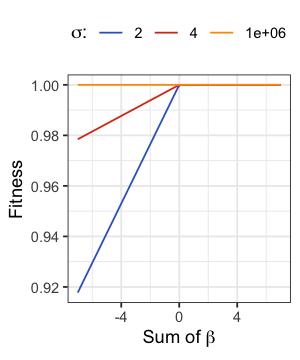

In [5]:
h <- 3
w <- 2.5
options(repr.plot.width=w, repr.plot.height=h)

p <- ggplot(data=dat, aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
# p <- p + geom_point(aes(x=x, y=fitness))
p <- p + geom_line(aes(x=x, y=fitness))
p <- p + xlab(expression(paste("Sum of ", beta))) + ylab('Fitness')
p <- p + labs(color=expression(paste(sigma, ":"))) + theme(legend.position="top")
print(p)

pdf('figs/directional_fitness_paradigm.pdf', h=h, w=w)
print(p)
dev.off()

#### Detailed LD fig

In [6]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [7]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [8]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


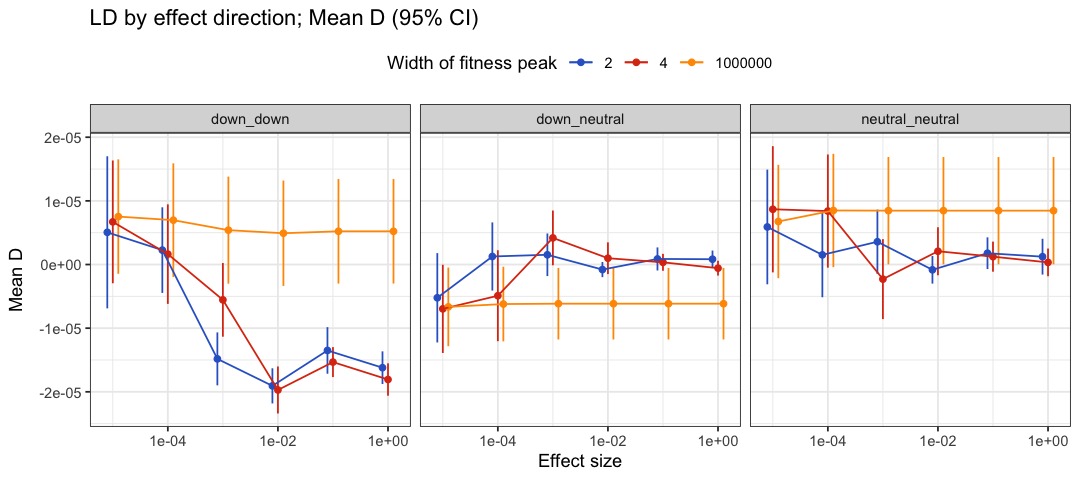

In [9]:
options(repr.plot.width=9, repr.plot.height=4)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all" &
                             dat_summary$type!="up_up" &
                             dat_summary$type!="up_down" &
                             dat_summary$type!="up_neutral" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

In [12]:
dat_summary[dat_summary$type=='down_neutral' & dat_summary$width=='1000000',]

width   beta  type         mean          median        stdev       
1 1000000 1e+00 down_neutral -6.154021e-06 -2.009535e-06 4.030724e-05
2 1000000 1e-01 down_neutral -6.154021e-06 -2.009535e-06 4.030724e-05
3 1000000 1e-02 down_neutral -6.154021e-06 -2.009535e-06 4.030724e-05
4 1000000 1e-03 down_neutral -6.154021e-06 -2.009535e-06 4.030724e-05
5 1000000 1e-04 down_neutral -6.209718e-06 -1.864689e-06 4.020256e-05
6 1000000 1e-05 down_neutral -6.654176e-06 -2.548952e-06 4.069203e-05
  stderr       count
1 2.850152e-06 200  
2 2.850152e-06 200  
3 2.850152e-06 200  
4 2.850152e-06 200  
5 2.971859e-06 183  
6 3.130156e-06 169

#### simplified fig

In [480]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [481]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [482]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

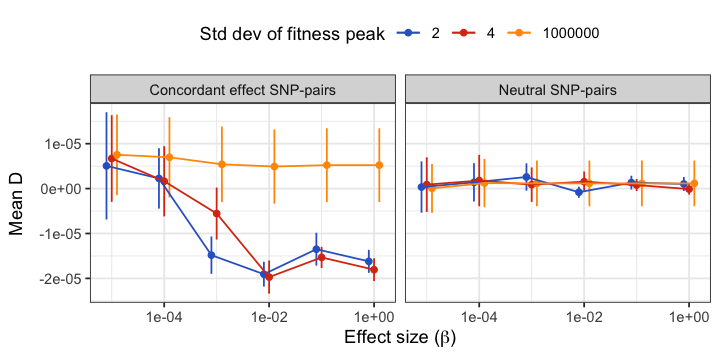

In [483]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
                             dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [9]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [10]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [11]:
require(dplyr)

N <- 1000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [12]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

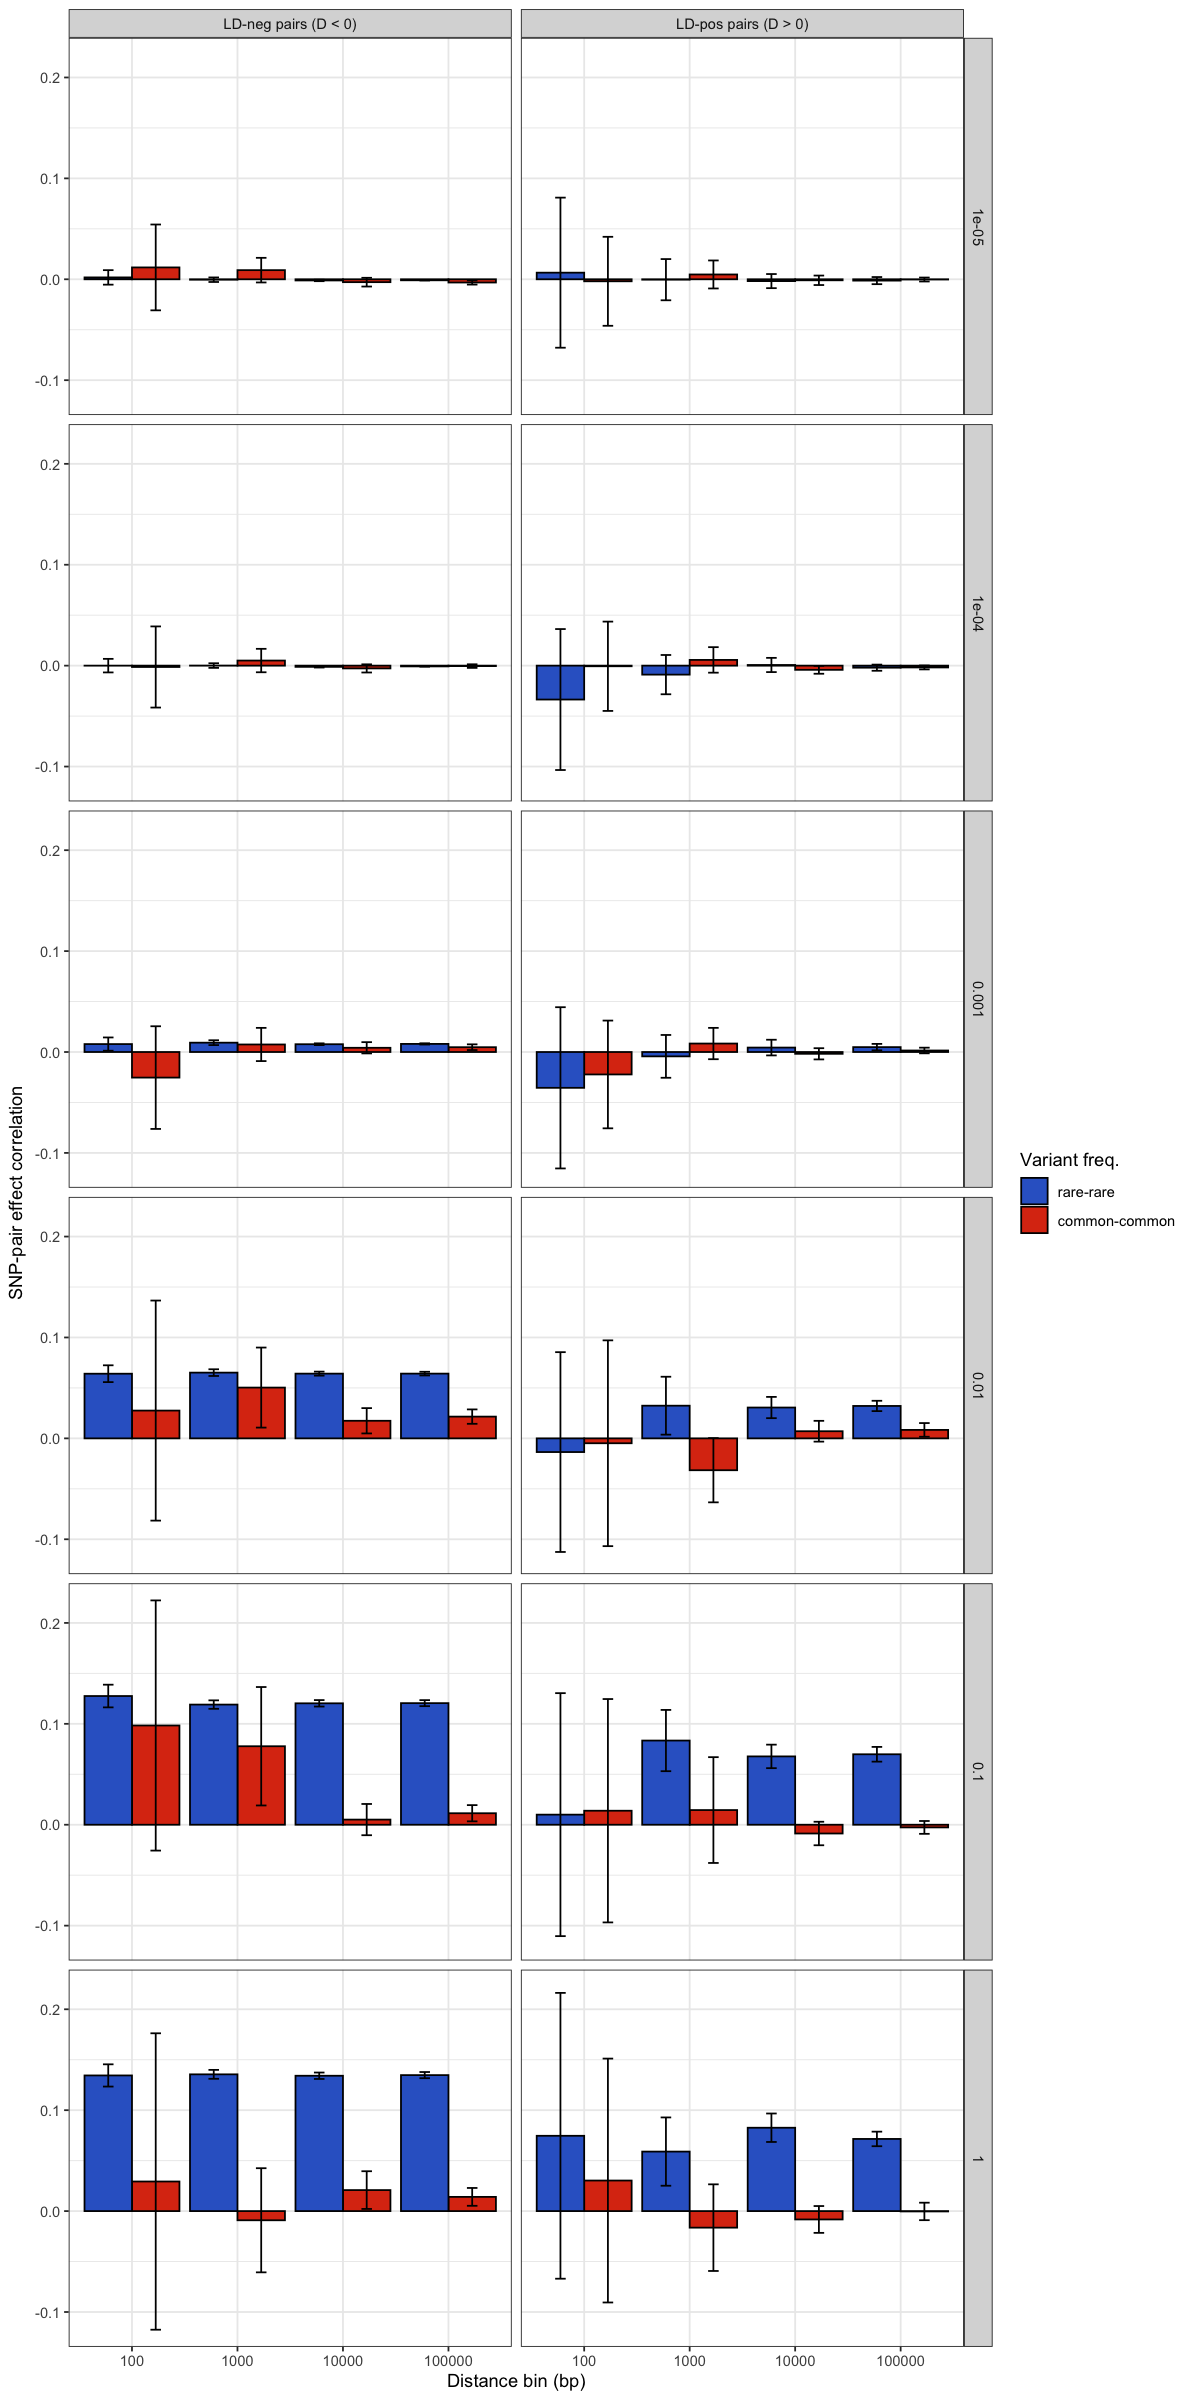

In [17]:
# w <- 6
# h <- 2.5

w <- 10
h <- 20


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==2,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

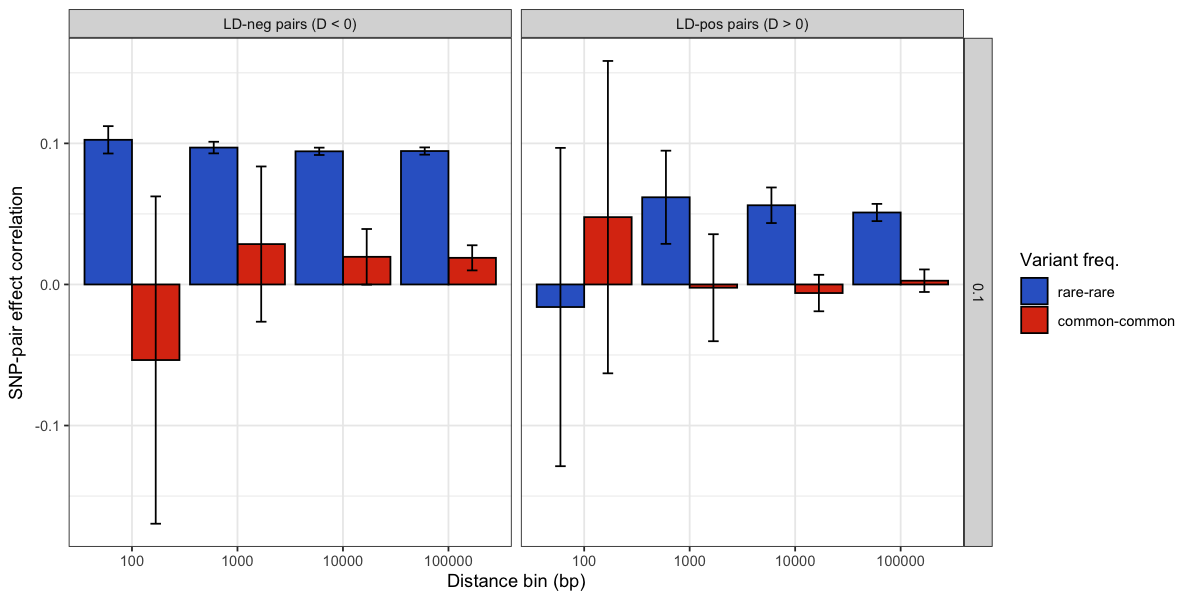

In [13]:
# w <- 6
# h <- 2.5

w <- 10
h <- 5


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             dat_summary$width==4 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

## r05.1

Now using a normal distribution of $\beta$ values and Gravel population model

```bash
RUN=r05.1
N=1000

mkdir -p log
for SD in 2
do
    for WIDTH in 2 4 1000000
    do
        OUTDIR=w${WIDTH}/sd${SD}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}
        sbatch \
            --array=1-2%20 \
            -c 1 \
            -t 0-00:30 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH} \
            -o log/$RUN.w${WIDTH}.%a.out \
            ./submit_array.sh \
                -w ${SD} -N ${N} -o $OUTDIR
    done
done
```

```bash
# # individual trial slim run
# time slim \
#     -d seed=10000 \
#     -d sd=2 \
#     -d sample_size=10000 \
#     -d "out_prefix='test'" \
#     slim_cmd.slim
```

Compile summary stats

```bash
N=1000
MIN_FREQ=0

for SD in 2
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-01:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.sd${SD} \
            -o log/st.$RUN.w${WIDTH}.sd${SD}.%A.out \
            ./summarize_type.sh $WIDTH $SD $N $MIN_FREQ
    done
done

sq | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash

for SD in 2
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/sd${SD}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4 1e-5
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [40]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r05.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [47]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$sd)
dat$effect <- factor(dat$sd, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [63]:
require(dplyr)

N <- 1000
# u <- 1e-8
# theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, sd, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$sd <- as.numeric(as.character(dat_summary$sd))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'sd'. You can override using the `.groups` argument.


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



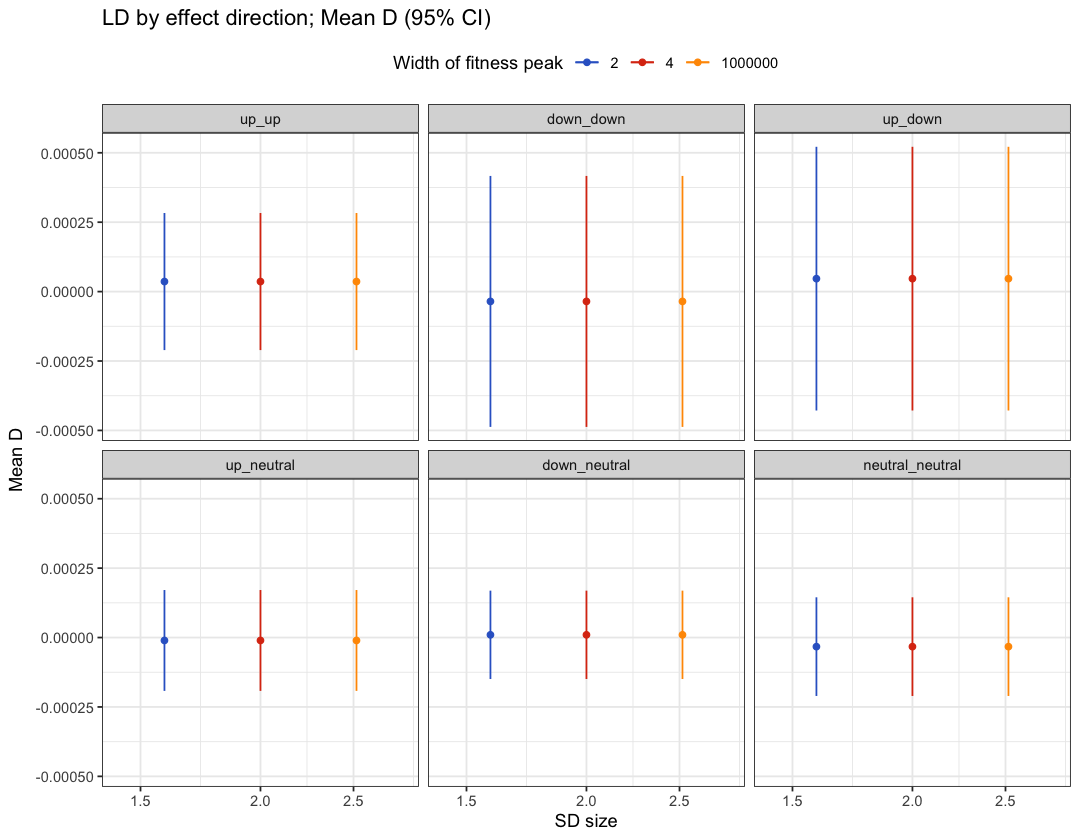

In [55]:
options(repr.plot.width=9, repr.plot.height=7)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all" & dat_summary$sd < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=sd, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = sd, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=sd, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('SD size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [60]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r05.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [61]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$effect <- as.factor(dat$effect)
dat$effect <- factor(dat$effect, levels=rev(levels(dat$effect)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

ERROR: Error in `$<-.data.frame`(`*tmp*`, effect, value = structure(integer(0), .Label = character(0), class = "factor")): replacement has 0 rows, data has 42


In [62]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, effect, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
Column `effect` is not found.
Column `type.simp` is not found.


pdf 
  2

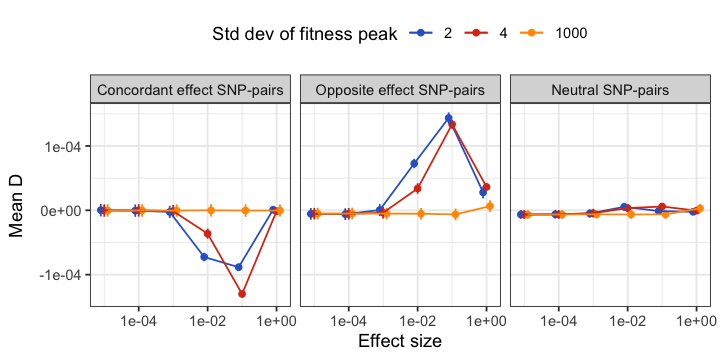

In [59]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" & dat_summary$effect < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = effect, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=effect, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [9]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r04.1')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [23]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)

In [32]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'bin', 'class'. You can override using the `.groups` argument.


In [33]:
# there is a mistake in my script, so 100000 should be 10000 bin
# 2023-07-10: I think i fixed this, so now there is a 10000 bin as well.
dat_summary$bin <- factor(dat_summary$bin, levels = c("100", "1000", "10000","100000"),
                  labels = c("100", "1000", "10000","100000"))

# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

pdf 
  2

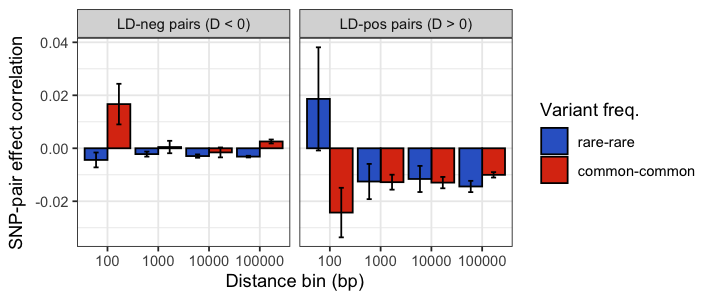

In [35]:
w <- 6
h <- 2.5

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" & dat_summary$bin != 1000000,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(. ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
print(p)
dev.off()

```bash

slim \
    -s 10000 \
    -d reg_length=100000 \
    -d dom_coeff=0.5 \
    -d recomb_rate=0 \
    -d mu=1e-8 \
    -d pop_size=10000 \
    -d width=2 \
    -d beta=-1e-1 \
    -d "out_prefix='test'" \
    1.slim_cmd.slim
```

```bash
time slim -d seed=1000 -d sd=2 -d "out_prefix='test1'" gravel_stabilizing_selection.slim
# real	22m15.183s
# user	22m8.412s
# sys	0m6.390s

time ./parse_vcf_gravel.py test1.vcf
# real	1m7.498s
# user	1m7.107s
# sys	0m0.255s
```

```bash
cat this.sh
# #!/usr/bin/bash

# time slim -d seed=1000 -d sd=2 -d "out_prefix='test2'" gravel_stabilizing_selection.slim

sbatch \
    -c 1 \
    -t 0-02:00 \
    -p short \
    --mem=4g \
    -J test \
    -o log.out \
    ./this.sh

```

## r06.3

Similar to r06.2 except this is pure directional selection (positive and negative selection variants)

- simulation of __directional selection__ (only neutral and trait decreasing variants)
- Fixed population size N=10000
- Recombination
- No downsampling for LD calculations
- 2023-08-28: Problem with colliding seeds under certain selection parameters, so multiplying SEED by WIDTH

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -s 10 \
    -d pop_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d dom_coeff=0.5 \
    -d reg_length=100000 \
    -d recomb_rate=1e-8 \
    -d mu=1e-8 \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Batch run

```bash
RUN=r06.3
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=4801-5000%50 \
            -c 1 \
            -t 0-02:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only
- This is not needed

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [232]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [233]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [234]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


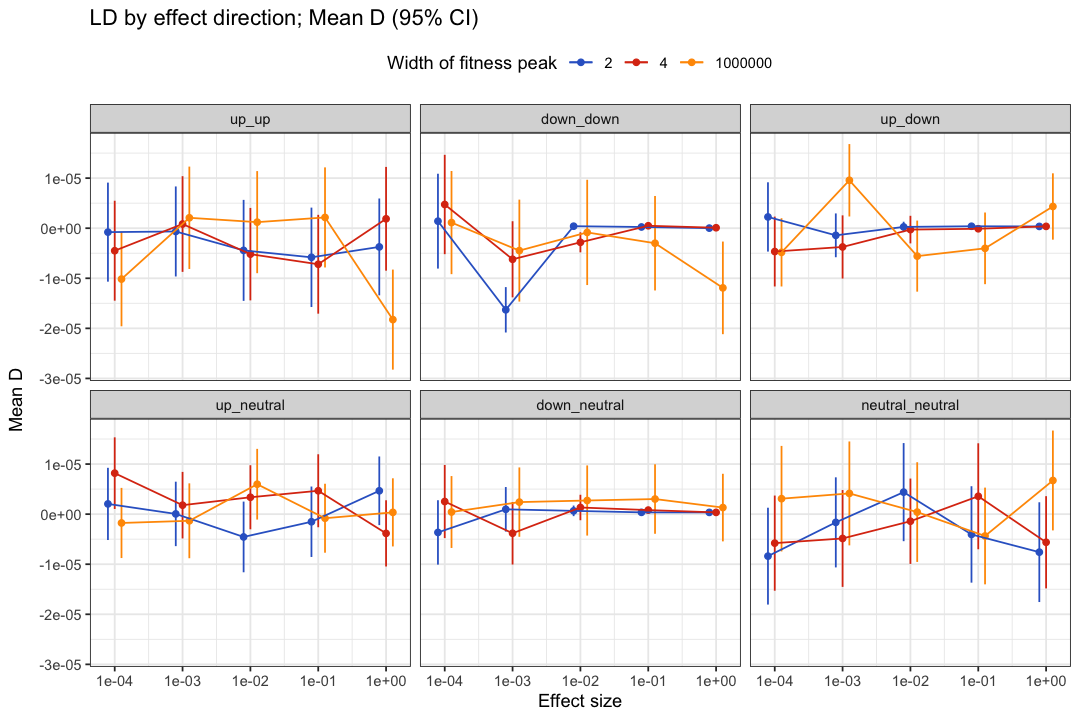

In [235]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [236]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [237]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [238]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

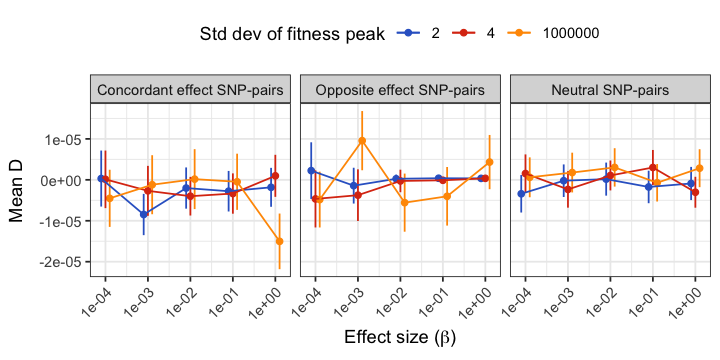

In [239]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [256]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [257]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [258]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [259]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

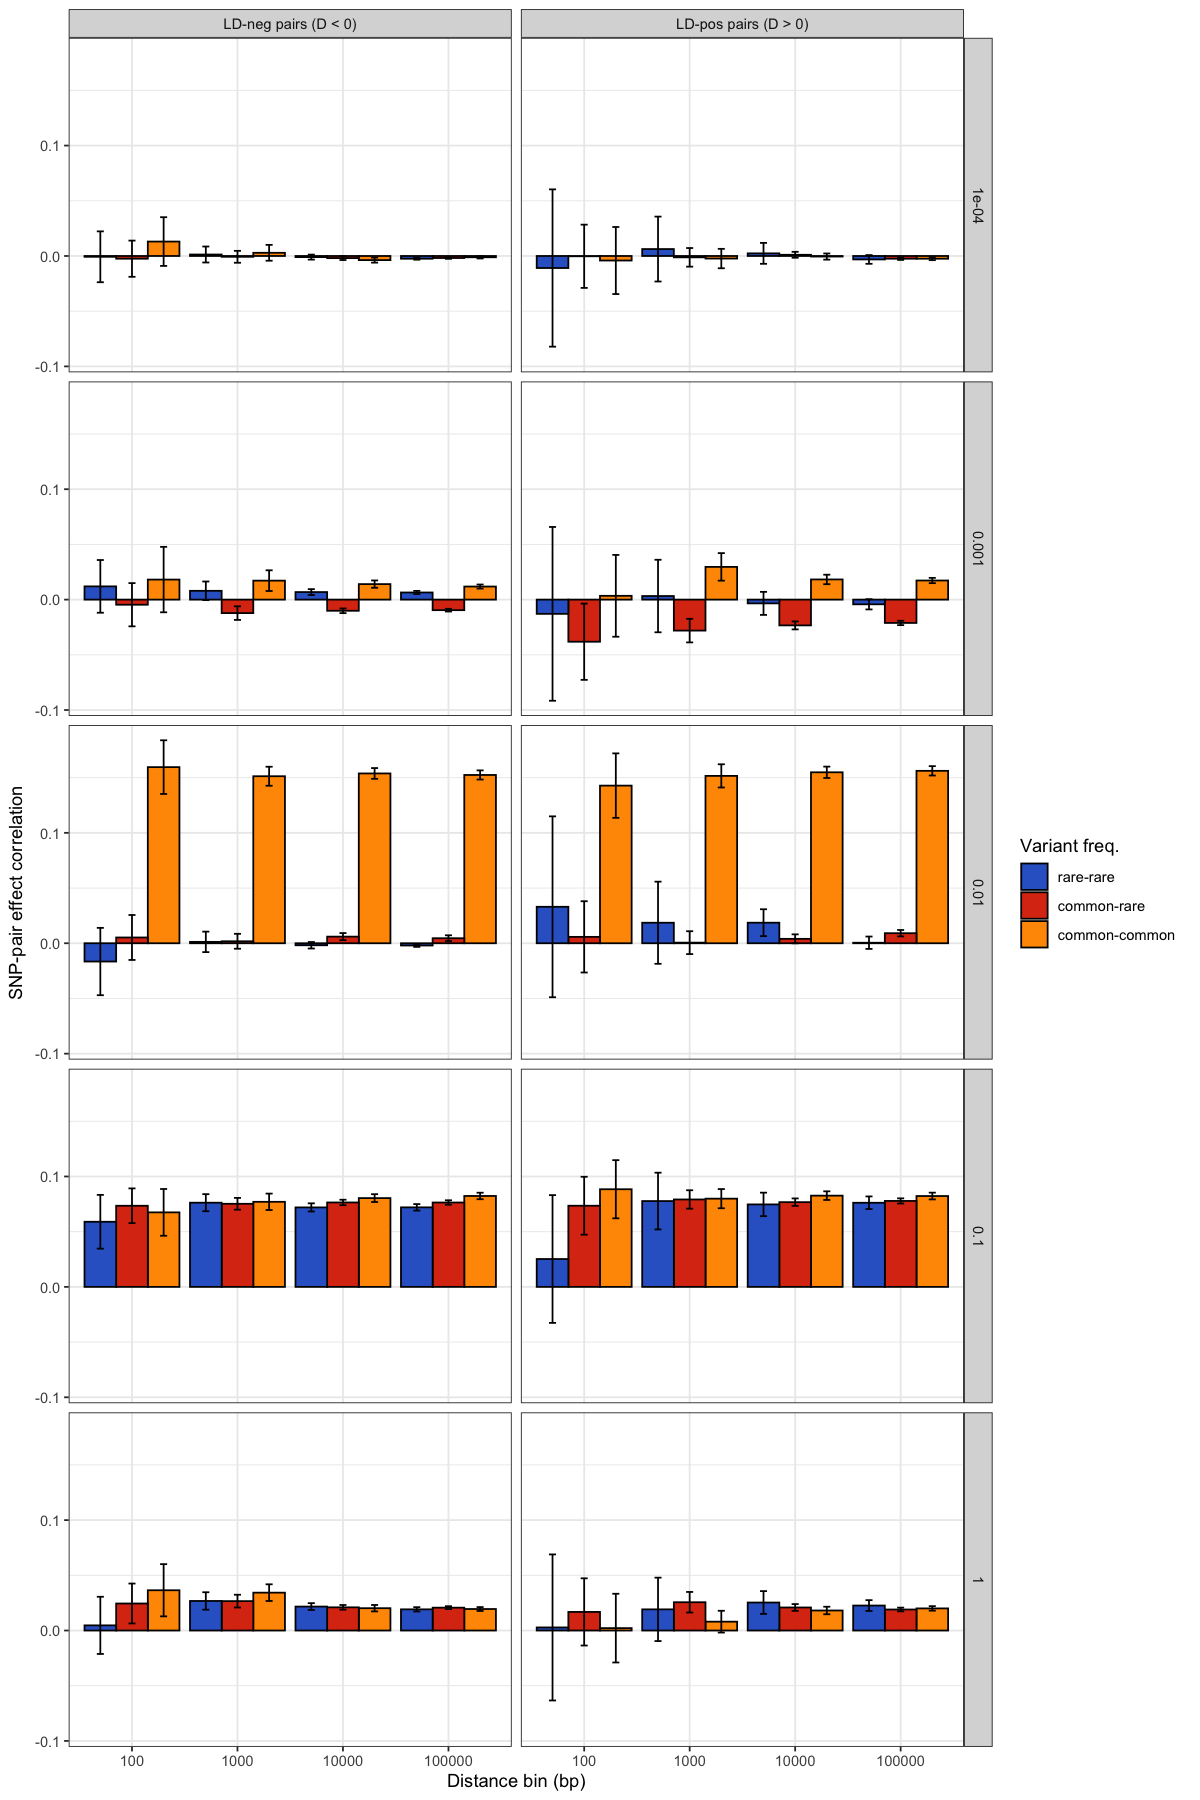

In [260]:
# w <- 6
# h <- 2.5

w <- 10
h <- 15


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[
#                              dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

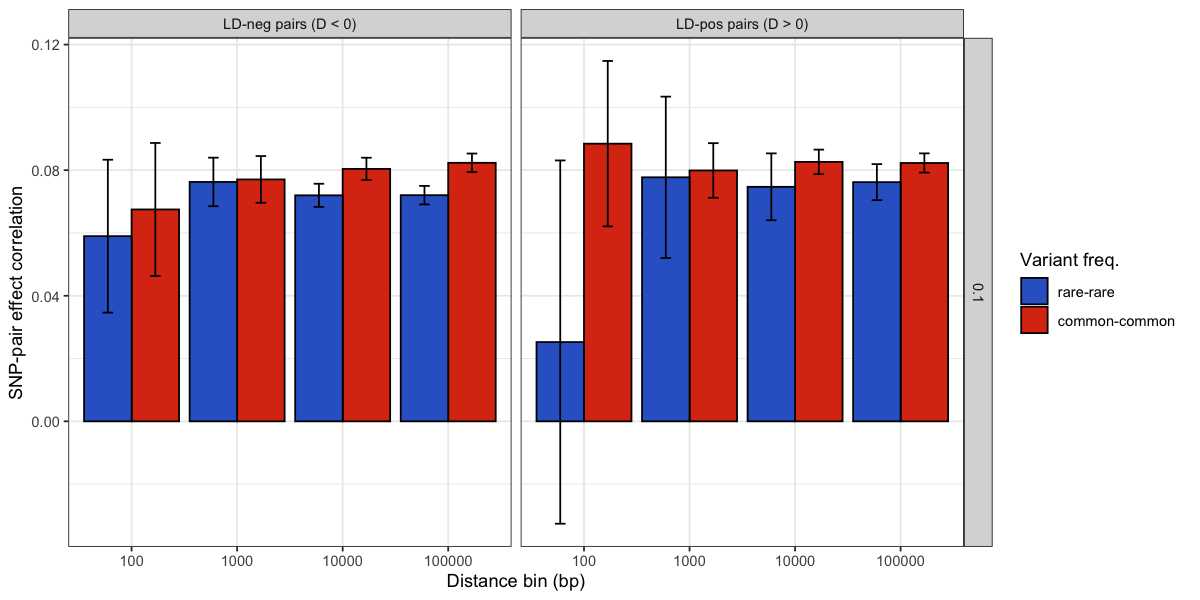

In [261]:
# w <- 6
# h <- 2.5

w <- 10
h <- 5


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

## r06.4

2023-11-03

Directional selection
- both trait-increasing and trait-decreasing variants exist, but fitness is determined only by the __number__ of mutations. (i.e. trait-increasing and trait-decreasing variants do not cancel each other out)
- Fixed population size N=10000
- Recombination
- No downsampling for LD calculations
- 2023-08-28: Problem with colliding seeds under certain selection parameters, so multiplying SEED by WIDTH

```bash
WIDTH=2
BETA=1e-1
OUTPREFIX=test

time slim \
    -s 10 \
    -d pop_size=10000 \
    -d width=${WIDTH} \
    -d beta=${BETA} \
    -d dom_coeff=0.5 \
    -d reg_length=100000 \
    -d recomb_rate=1e-8 \
    -d mu=1e-8 \
    -d "out_prefix='${OUTPREFIX}'" \
    slim_cmd.slim

```

### Batch run

```bash
RUN=r06.4
RECOMB=1e-8
REG_SIZE=100000
DOM_COEFF=0.5
N=10000
MU=1e-8

mkdir -p log
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        mkdir -p $OUTDIR
        echo WIDTH ${WIDTH}, BETA ${BETA}
        sbatch \
            --array=1801-2400%50 \
            -c 1 \
            -t 0-02:00 \
            --mem=500M \
            -p short \
            -J $RUN.w${WIDTH}.b${BETA} \
            -o log/$RUN.w${WIDTH}.b${BETA}.%a.out \
            ./submit_array.sh \
                -N ${N} -R ${REG_SIZE} -w ${WIDTH} -b ${BETA} -d ${DOM_COEFF} -u $MU -r ${RECOMB} -o $OUTDIR
    done
done
```

Compile summary stats

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_type.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

Compile summary stats for covariation only
- This is not needed

```bash
N=10000
MIN_FREQ=0

for BETA in 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        sbatch \
            -c 1 \
            -t 0-12:00 \
            -p short \
            --mem=60 \
            -J st.$RUN.w${WIDTH}.b${BETA} \
            -o log/st.$RUN.w${WIDTH}.b${BETA}.%A.out \
            ./summarize_cov.sh $WIDTH $BETA $N $MIN_FREQ
    done
done

sq | grep PEND | grep st | awk '{ print $1 }' | xargs -I{} scontrol top {}
```

merge across selection coeff

```bash
N=10000
MIN_FREQ=0

for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        cat w${WIDTH}/b${BETA}/summary_stats_type.min_frq_${MIN_FREQ}.txt
    done
done \
    | awk 'NR==1 || $0!~"^type"' \
    | gzip -c \
    > summary_stats_type.min_frq_${MIN_FREQ}.txt.gz
```

merge covariance stats across selection coeff
```bash

echo "beta,width,bin,class,corr_class,dist,prod,corr,cov" | gzip -c > summary_cov.min_frq_0.txt.gz
for BETA in 1e0 1e-1 1e-2 1e-3 1e-4
do
    for WIDTH in 2 1000000 4
    do
        OUTDIR=w${WIDTH}/b${BETA}
        OUTFILE=$OUTDIR/summary_cov.min_frq_${MIN_FREQ}.txt
        cat $OUTFILE | sed 1d \
            | awk -v BETA=$BETA -v WIDTH=$WIDTH '{ print BETA","WIDTH","$0 }'
    done
done | gzip -c >> summary_cov.min_frq_0.txt.gz
```

### Figures

#### Detailed LD fig

In [262]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.4')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [263]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type, levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

In [264]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


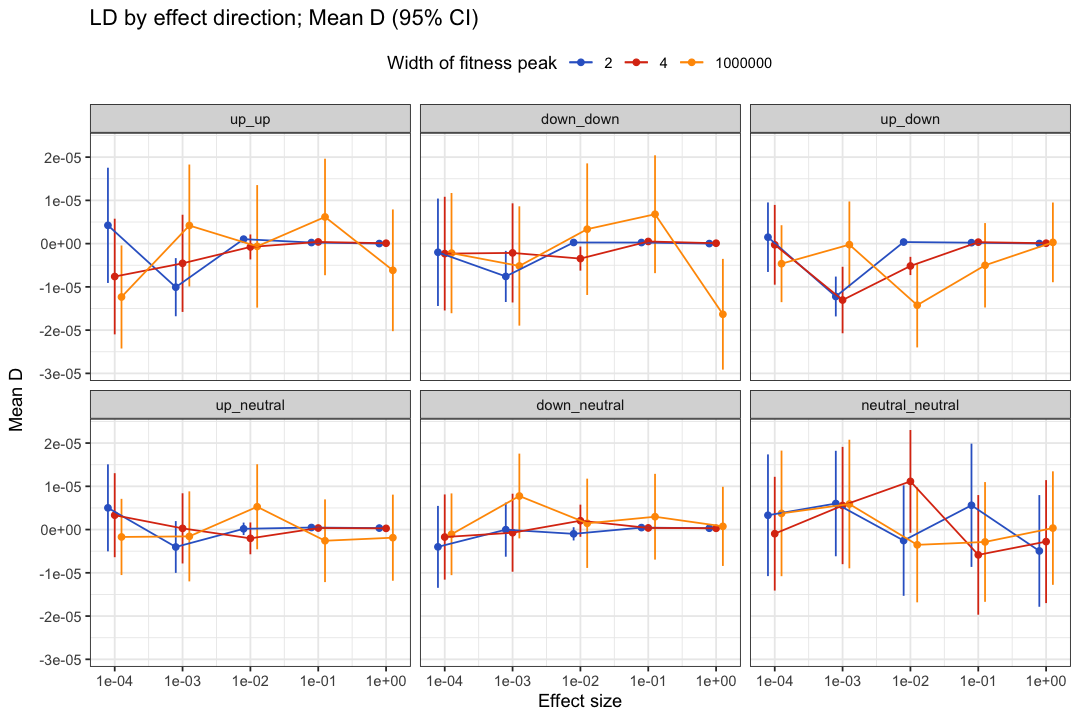

In [265]:
options(repr.plot.width=9, repr.plot.height=6)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type!="all",], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
p <- p + ggtitle(paste0('LD by effect direction',
                        '; Mean D (', ci*100,
                        '% CI)'))
p <- p + xlab('Effect size') + ylab('Mean D')
p <- p + labs(color='Width of fitness peak') + theme(legend.position="top")
print(p)

#### simplified fig

In [266]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.3')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [267]:
dat <- read.table('summary_stats_type.min_frq_0.txt.gz', header=T)
dat$beta <- as.factor(dat$beta)
dat$beta <- factor(dat$beta, levels=rev(levels(dat$beta)))

dat$width <- as.factor(dat$width)

dat$type <- factor(dat$type,
                   levels=c("up_up", "down_down", "up_down", "up_neutral", "down_neutral", "neutral_neutral", "all"))

dat$type.simp <- factor(dat$type, levels = c("up_up", "down_down",
                                             "up_down",
                                            "up_neutral", "down_neutral", "neutral_neutral",
                                             "all"),
                  labels = c("Concordant effect SNP-pairs", "Concordant effect SNP-pairs",
                             "Opposite effect SNP-pairs",
                             "Neutral SNP-pairs", "Neutral SNP-pairs", "Neutral SNP-pairs",
                             "All"))

In [268]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(width, beta, type.simp) %>%
    summarise(mean = mean(D_mean, na.rm = TRUE), median = median(D_mean, na.rm = TRUE),
              stdev = sd(D_mean, na.rm = TRUE),
              stderr = sd(D_mean, na.rm = TRUE)/sqrt(length(D_mean[!is.na(D_mean)])),
              count = length(D_mean[!is.na(D_mean)]))

dat_summary$beta <- as.numeric(as.character(dat_summary$beta))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'width', 'beta'. You can override using the `.groups` argument.


pdf 
  2

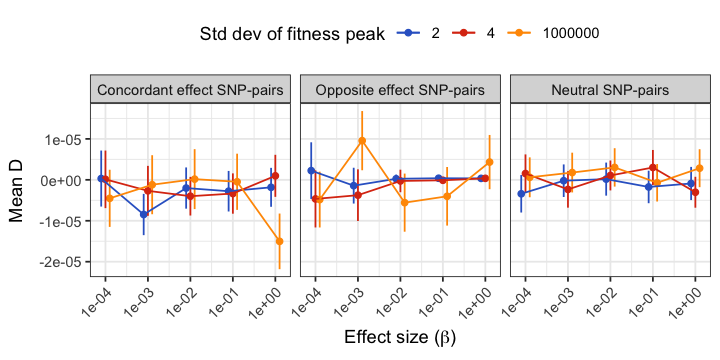

In [269]:
w <- 6
h <- 3

options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.3

p <- ggplot(data=dat_summary[dat_summary$type.simp!="All" &
#                              dat_summary$type.simp!="Opposite effect SNP-pairs" &
                             dat_summary$beta < 10,], aes(col=width)) + theme_bw() + scale_color_gdocs()
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_point(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + geom_errorbar(aes(x = beta, ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0, position=position_dodge(dodge_amt))
p <- p + geom_line(aes(x=beta, y=mean), position=position_dodge(dodge_amt))
p <- p + facet_wrap(type.simp ~ .)
# p <- p + geom_point(aes(x=-s, y=median))
# p <- p + coord_cartesian(xlim = c(1e-5, 1e-2))
#     p <- p + coord_cartesian(xlim = c(1e-5, 1e-2), ylim=c(-1e-3, 1e-3))
p <- p + scale_x_log10()
# p <- p + geom_vline(xintercept = theta, linetype = 'dashed')
# p <- p + ggtitle(paste0('LD by effect direction',
#                         '; Mean D (', ci*100,
#                         '% CI)'))
# p <- p + xlab('Effect size')
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + xlab(expression(paste("Effect size (", beta, ")")))
p <- p + ylab('Mean D')
p <- p + labs(color='Std dev of fitness peak') + theme(legend.position="top")
print(p)

pdf('figs/ld_beta_sign.pdf', h=h, w=w)
print(p)
dev.off()

#### beta cov

In [270]:
setwd('/Users/cchiang/research/sunyaev/projects/epi/expts/stabilizing_sim_2021-09-28/r06.4')

library('ggplot2')
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=9)

In [271]:
dat <- read.csv('summary_cov.min_frq_0.txt.gz', header=T)
dat <- dat[!is.na(dat$corr_class),]

In [272]:
require(dplyr)

N <- 10000
u <- 1e-8
theta <- 4 * N * u

dat_summary <- 
    dat %>%
    group_by(beta, width, bin, class, corr_class) %>%
    summarise(mean = mean(prod, na.rm = TRUE),
              median = median(prod, na.rm = TRUE),
              stdev = sd(prod, na.rm = TRUE),
              stderr = sd(prod, na.rm = TRUE)/sqrt(length(prod[!is.na(prod)])),
              count = length(prod[!is.na(prod)]))

dat_summary$cat <- paste(dat_summary$bin, dat_summary$corr_class, sep="_")
# dat_summary$effect <- as.numeric(as.character(dat_summary$effect))
# dat_summary$sc <- as.numeric(as.character(dat_summary$sc))

`summarise()` has grouped output by 'beta', 'width', 'bin', 'class'. You can override using the `.groups` argument.


In [273]:
# rename low to rare
dat_summary$class <- factor(dat_summary$class, levels = c("low-low", "common-low", "common-common"),
                  labels = c("rare-rare", "common-rare", "common-common"))

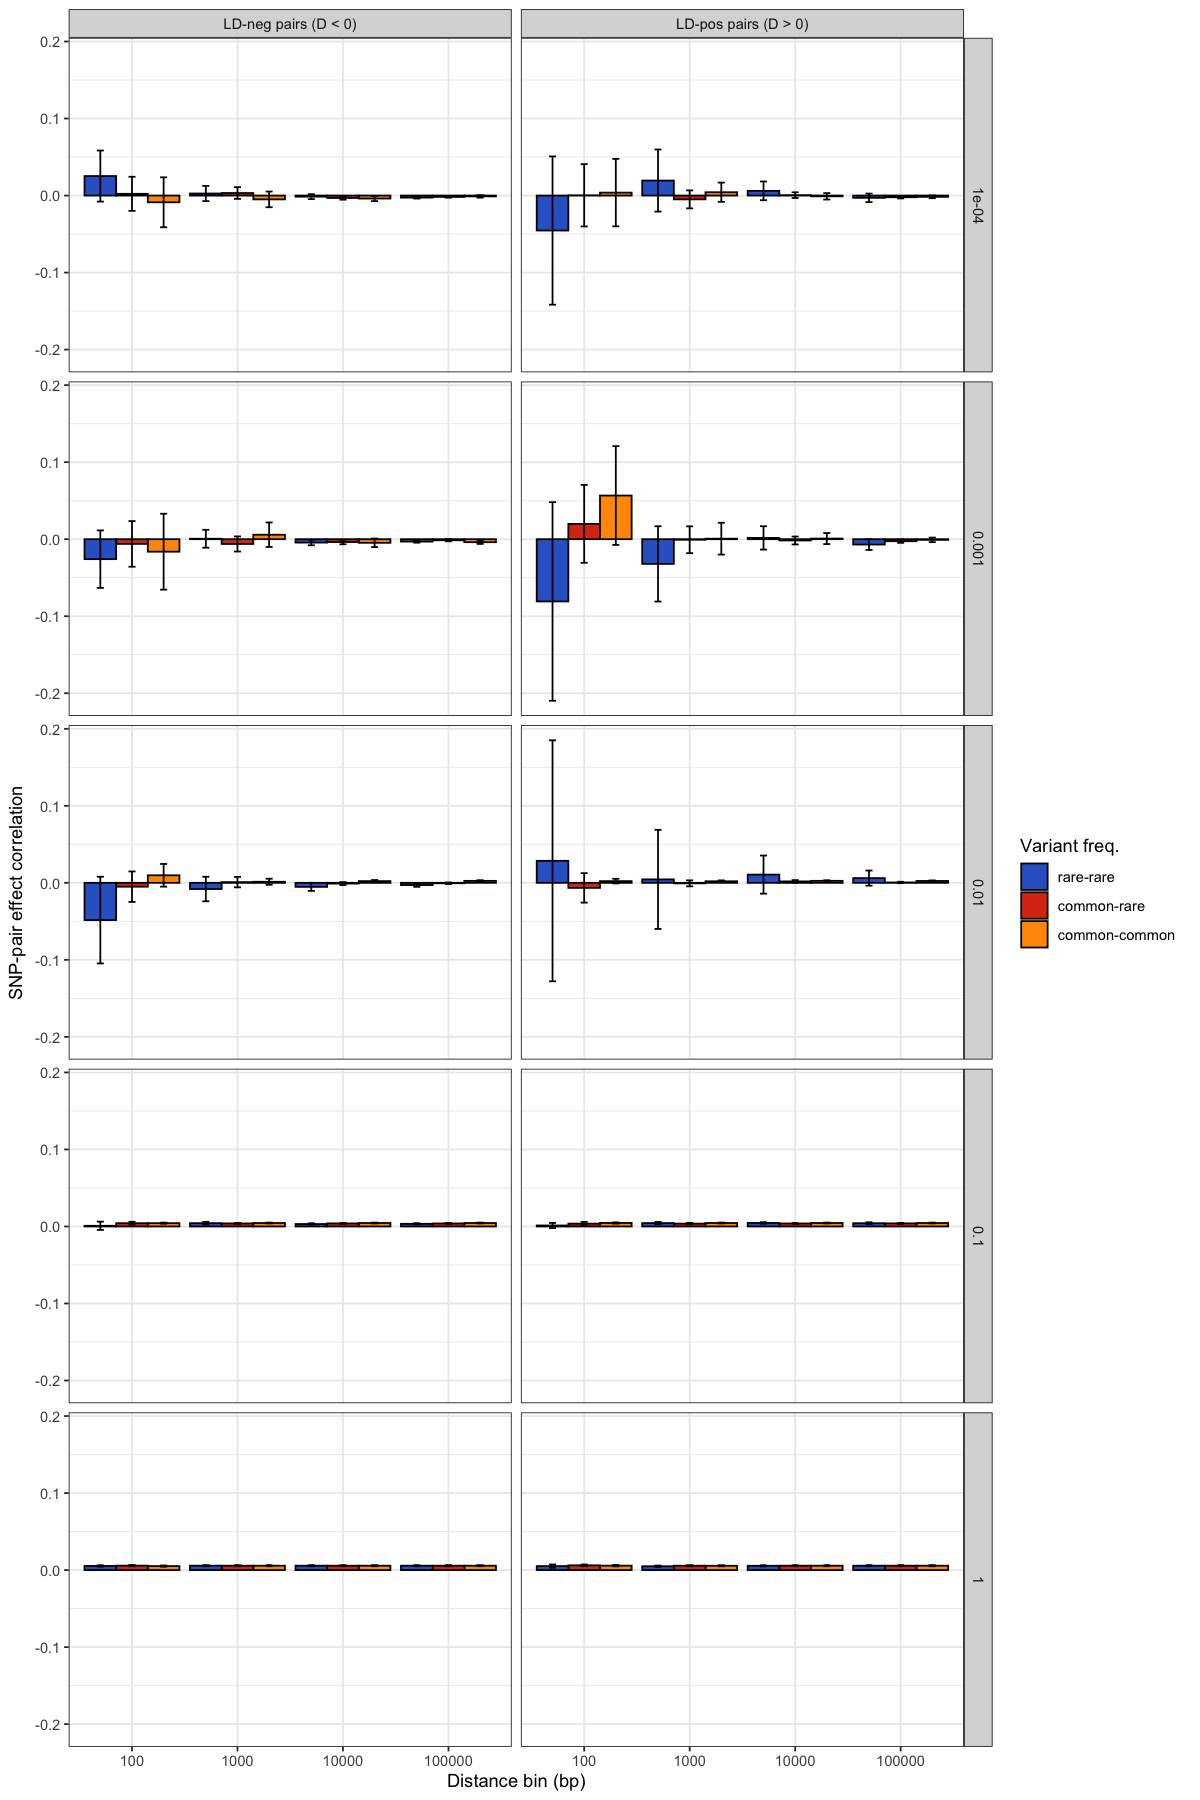

In [274]:
# w <- 6
# h <- 2.5

w <- 10
h <- 15


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[
#                              dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()

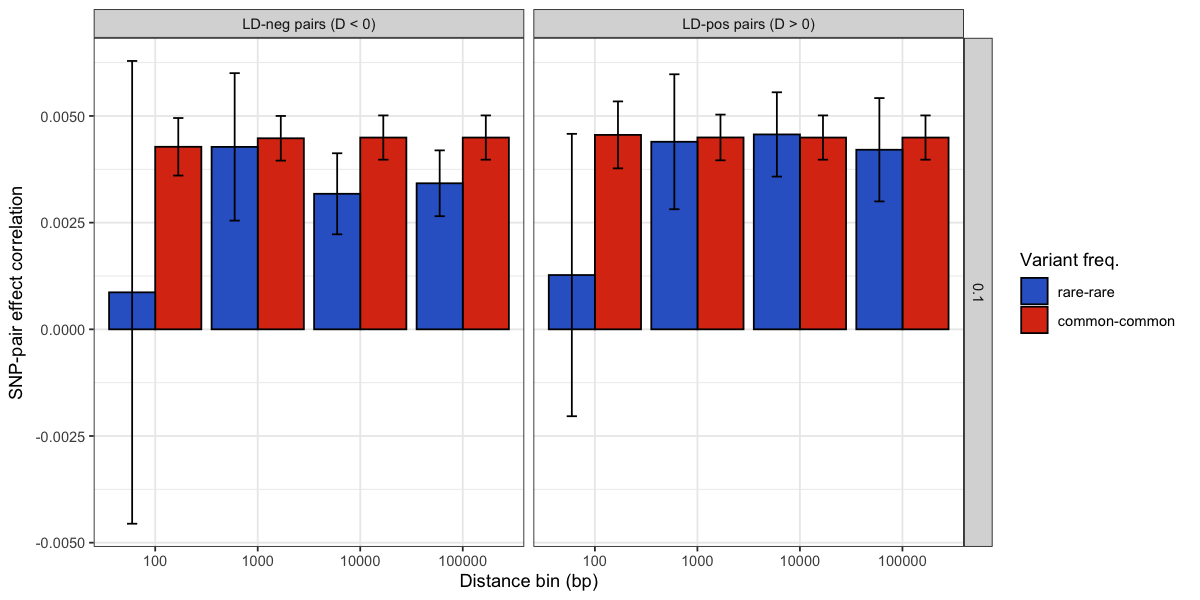

In [275]:
# w <- 6
# h <- 2.5

w <- 10
h <- 5


options(repr.plot.width=w, repr.plot.height=h)
ci <- 0.95
dodge_amt <- 0.9

# New facet label names for corr_class variable
corr_class.labs <- c("LD-neg pairs (D < 0)", "LD-pos pairs (D > 0)")
names(corr_class.labs) <- c("neg", "pos")


p <- ggplot(data=dat_summary[dat_summary$class != "common-rare" &
                             !is.na(dat_summary$class) &
                             dat_summary$width==2 &
                             dat_summary$beta==1e-1,],
            aes(x=as.factor(bin), y=mean, fill=class)) + theme_bw() + scale_color_gdocs() + scale_fill_gdocs()
# p <- p + theme(panel.grid.minor = element_blank())
# p <- p + geom_vline(xintercept = 1/N, linetype = 'dashed', color='gray')
p <- p + geom_bar(stat='identity', color='black', position = position_dodge(width = dodge_amt))
p <- p + geom_errorbar(aes(x=as.factor(bin),
#                            position = 'dodge',
                           ymin=mean-stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE),
                           ymax=mean+stderr * qt(p=(1-ci)/2, df=count-1, lower.tail=FALSE)
                          ),
                       width=0.2, position=position_dodge(dodge_amt))
# p <- p + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p <- p + facet_grid(beta  ~ corr_class,
                    labeller = labeller(corr_class = corr_class.labs))
p <- p + ylab('SNP-pair effect correlation')
p <- p + xlab('Distance bin (bp)')
p <- p + labs(fill='Variant freq.') + theme(legend.position="right")
print(p)

# pdf('figs/SNP_effect_pair_corr_w2_beta1e-2.pdf', h=h, w=w)
# print(p)
# dev.off()